In [17]:
import xarray as xr
import numpy as np
import sys; sys.path.append('../')
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Drake Passage averages over the last 1000 days

In [2]:
from functools import cache
@cache
def interface(exp='R4-long/bare', lon=0, layer=None):
    if exp=='R32':
        ds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)
    else:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/longmean_00029050.nc', decode_times=False)
        except:
            # Return NaNs instead
            print(f'Experiment /scratch/pp2681/mom6/Neverworld2/simulations/{exp} exploded')
            ds = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False, chunks={'time':1}).isel(time=slice(0,1)) * np.nan
                                                                                                                                                
    e = ds.e
    
    if lon is not None:
        # lon=0,15,30,45
        if lon == 0:
            e = e.isel(xh=0)
        else:
            e = e.interp(xh=lon)
    
    if layer is not None:
        # layer = 0 is ssh
        e = e.isel(zi=layer)

    return e.mean('time').compute()

Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
CPU times: user 104 ms, sys: 30.6 ms, total: 134 ms
Wall time: 722 ms
CPU times: user 39.1 ms, sys: 40.6 ms, total: 79.8 ms
Wall time: 1.02 s


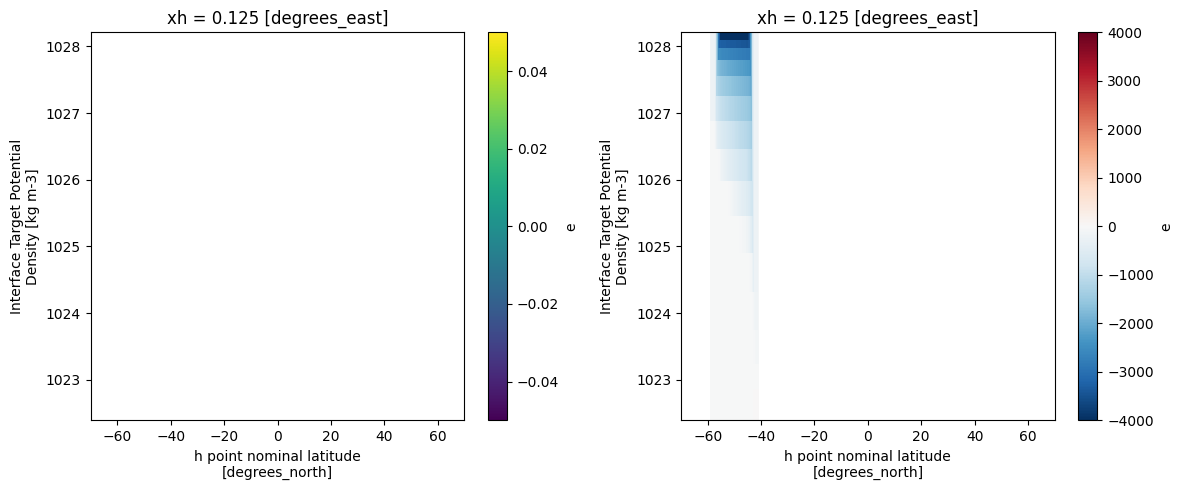

In [3]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
%time interface('R2-ANN/May-16-FCT-0').plot()
plt.subplot(1,2,2)
%time interface().plot()
plt.tight_layout()

In [3]:
def interfaces(exp='R4-long/bare', lon=0, layer=None, lat_max=None):
    '''
    Simple wrapper returning hires and lores interfaces
    '''
    hires = interface('R32', lon=lon, layer=layer).sel(yh=slice(None,lat_max))
    lores = interface(exp, lon=lon, layer=layer).sel(yh=slice(None,lat_max))

    if lon is None:
        factor = len(hires.xh) // len(lores.xh)
        return hires.coarsen({'xh': factor, 'yh': factor}).mean(), lores
    elif layer is None:
        return hires.interp(yh=lores.yh), lores
    else:
        print('Not implemented')

def rmse(hires, lores):
    error = (lores - hires)
    if 'zi' in error.dims:
        error = error.isel(zi=slice(0,15))
    RMSE = np.sqrt((error**2).mean()) # RMSE in metres
    return round(float(RMSE),3)

In [5]:
print(rmse(*interfaces(lon=0)))
print(rmse(*interfaces(lon=15)))
print(rmse(*interfaces(lon=30)))
print(rmse(*interfaces(lon=45)))
print(rmse(*interfaces(lon=None,layer=0)))
print(rmse(*interfaces(lon=None,layer=None)))

52.14
42.119
40.3
34.63
0.101
36.839


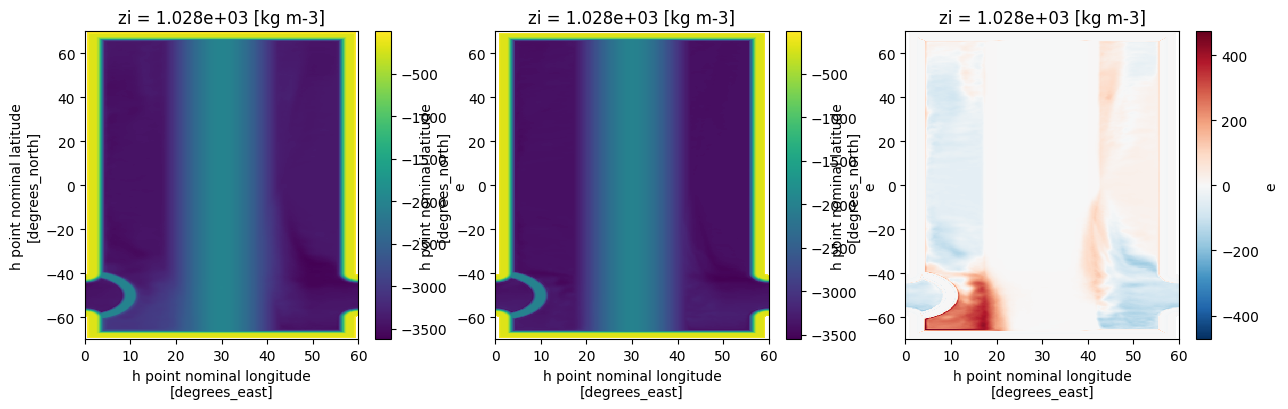

In [6]:
hires, lores = interfaces(lon=None,layer=None)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
hires.isel(zi=-2).plot()
plt.subplot(1,3,2)
lores.isel(zi=-2).plot()
plt.subplot(1,3,3)
(hires-lores).isel(zi=-2).plot()

In [4]:
def plot_interfaces(hires, lores):
    for zi in range(15):
        lores.isel(zi=zi).plot(ls='--', color='blue', lw=2)
        hires.isel(zi=zi).plot(ls='-', color='k', lw=2, alpha=0.5)
    hires.isel(zi=-1).plot(color='k') # show bathymetry 
    
    RMSE = rmse(hires,lores)
    plt.text(0.7,0.1,'RMSE=\n'+"{:.1f}".format(RMSE)+'$\,\mathrm{m}$', fontsize=15, transform = plt.gca().transAxes)
    plt.xlabel('Latitude, $^{\circ}\mathrm{S}$')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth, $\mathrm{m}$')
    plt.title('')

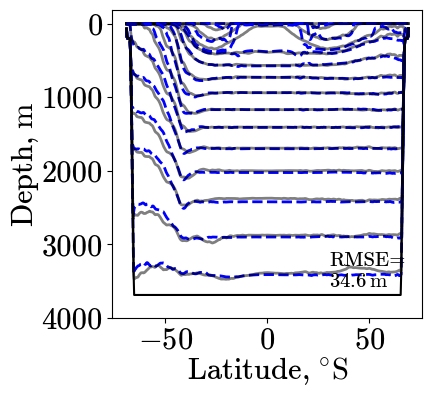

In [5]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plot_interfaces(*interfaces(lon=45))

In [6]:
%%time
RMSE = {}
for exp in ['FCT-0', 'inviscid', 
            'FCT-0-EXP2', 'Cs-0.03', 
            'Cs-0.06', 'Cs-0.01', 
            'FCT-0-Cs-0.00', 'FCT-0-Cs-0.01', 
            'FCT-0-Cs-0.03', 'FCT-0-Cs-0.06',
            'Cs-0.00', 'FCT-3', 'FCT-3-medium',
            'Cs-0.00-en-diss', 'Cs-0.01-en-diss']:
    for RR in ['R1', 'R2']:
        path = f'{RR}-ANN/May-16-{exp}'
        for lon in [0, 15, 30, 45]:
            RMSE[f'{RR}-{exp}-lon-{lon}'] = rmse(*interfaces(path, lon=lon))
        RMSE[f'{RR}-{exp}-ssh'] = rmse(*interfaces(path, lon=None, layer=0))
        RMSE[f'{RR}-{exp}-e3d'] = rmse(*interfaces(path, lon=None, layer=None))
        print('Done:', path)

Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/May-16-FCT-0 exploded
Done: R1-ANN/May-16-FCT-0
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May-16-FCT-0 exploded
Experiment /scratch/pp2681/mom6/Neverwo

In [ ]:
for path in ['R4-long/bare', 'R4-long/bare-Sadourny', 'R2-long/bare', 'R2-long/bare-Sadourny', 'R2-long/bare-Sadourny-en-diss', 'R2-long/Smooth', 'R2-long/Reynolds', 'R4-long/Reynolds-newest-code', 'R4-long/Smooth-filter-3D', 'R4-long/JansenHeld-Cs-0.2-Cback-0.1', 'R4-ANN/CM26_grid_harmonic_ver3-FCT', 'R2-ANN/CM26_grid_harmonic_ver3-FCT', 'R2-ANN/CM26_grid_harmonic_ver3-SGS-KE', 'R1-long/bare-Sadourny', 'R1-long/bare-Sadourny-en-diss', 'R1-ANN/CM26_grid_harmonic_ver3-FCT']:
    for lon in [0, 15, 30, 45]:
        RMSE[f'{path}-lon-{lon}'] = rmse(*interfaces(path, lon=lon))
    RMSE[f'{path}-ssh'] = rmse(*interfaces(path, lon=None, layer=0))
    RMSE[f'{path}-e3d'] = rmse(*interfaces(path, lon=None, layer=None))
    print('Done:', path)

Done: R4-long/bare
Done: R4-long/bare-Sadourny
Done: R2-long/bare
Done: R2-long/bare-Sadourny
Done: R2-long/bare-Sadourny-en-diss
Done: R2-long/Smooth
Done: R2-long/Reynolds
Done: R4-long/Reynolds-newest-code


In [ ]:
for path in ['R4-ANN/May-16-Cs-0.00', 'R4-ANN/May-16-Cs-0.01', 'R4-ANN/May-16-FCT-0-Cs-0.00', 'R4-ANN/May-16-FCT-3']:
    for lon in [0, 15, 30, 45]:
        RMSE[f'{path}-lon-{lon}'] = rmse(*interfaces(path, lon=lon))
    RMSE[f'{path}-ssh'] = rmse(*interfaces(path, lon=None, layer=0))
    RMSE[f'{path}-e3d'] = rmse(*interfaces(path, lon=None, layer=None))
    print('Done:', path)

In [9]:
def plot_metrics(cond1 = 'R2', cond2 = 'lon-0'):
    keys = []
    values = []
    for k,v in RMSE.items():
        if cond1 in k and cond2 in k:
            keys.append(k)
            values.append(v)
    idx = np.argsort(values)
    values = np.array(values)[idx]
    keys = np.array(keys)[idx]
    
    for j in range(len(keys)):
        plt.bar(keys[j], values[j], color='k' if 'bare' in keys[j] else 'gray')
    plt.xticks(np.arange(len(keys)), keys, rotation=90, fontsize=15);
    plt.ylabel('m')

Text(0.5, 1.0, 'RMSE at lon=15')

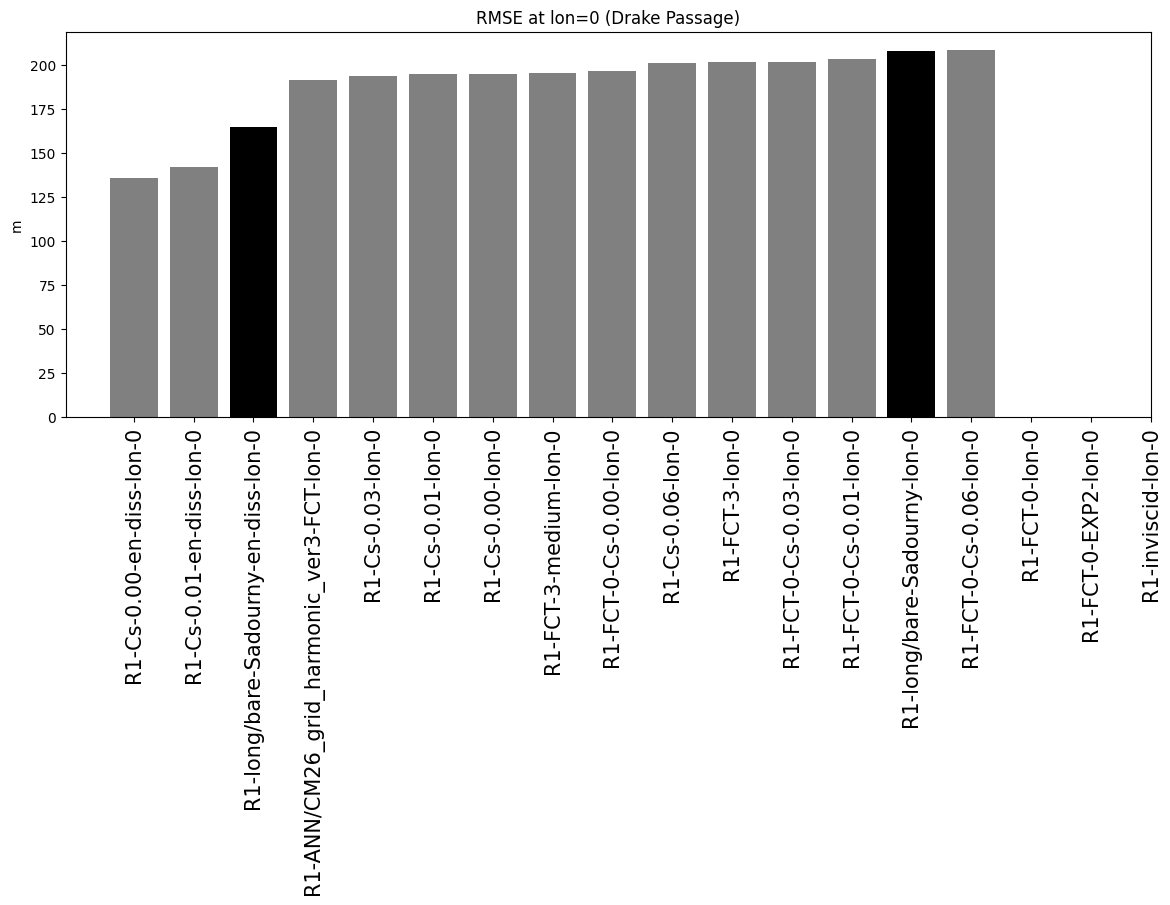

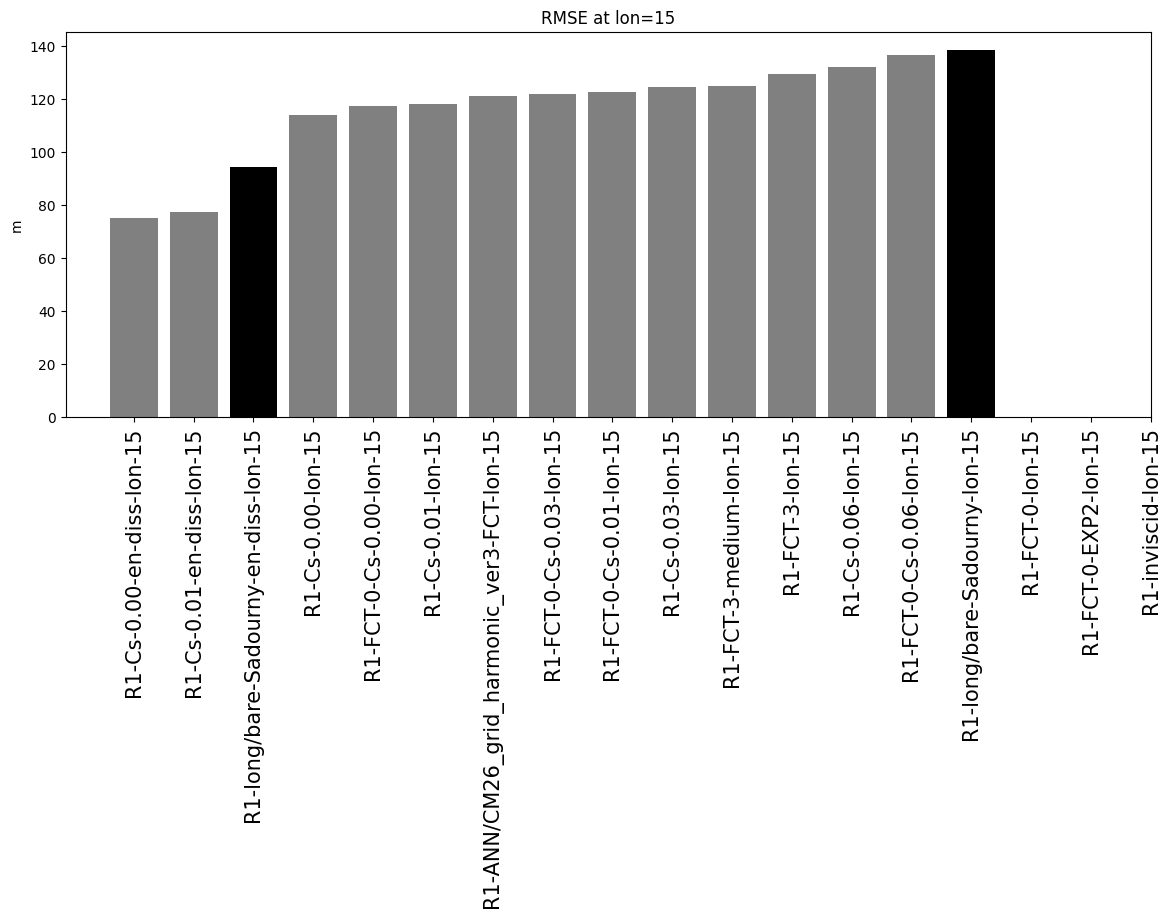

In [10]:
plt.figure(figsize=(14,5))
RR = 'R1'

plot_metrics(RR,'-lon-0')
plt.title('RMSE at lon=0 (Drake Passage)')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-15')
plt.title('RMSE at lon=15')

Text(0.5, 1.0, 'RMSE at lon=45')

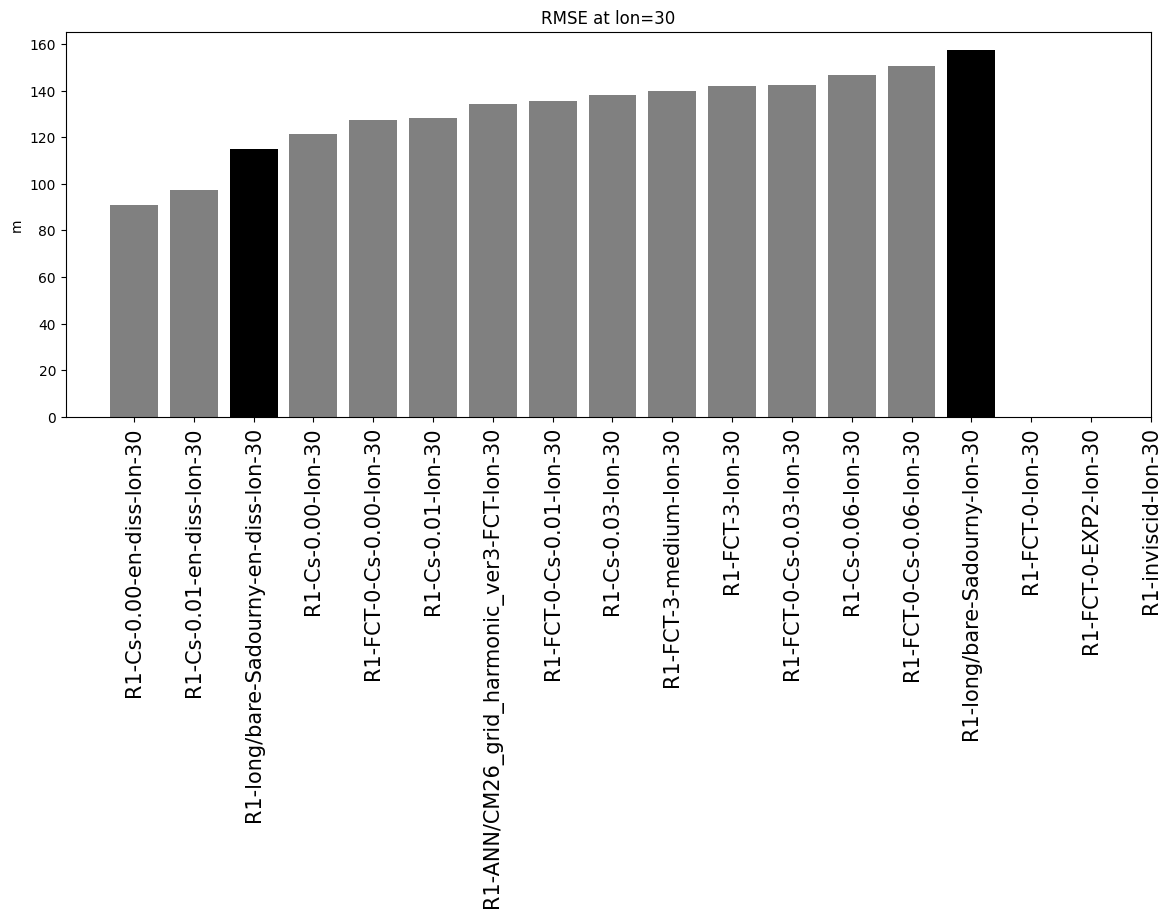

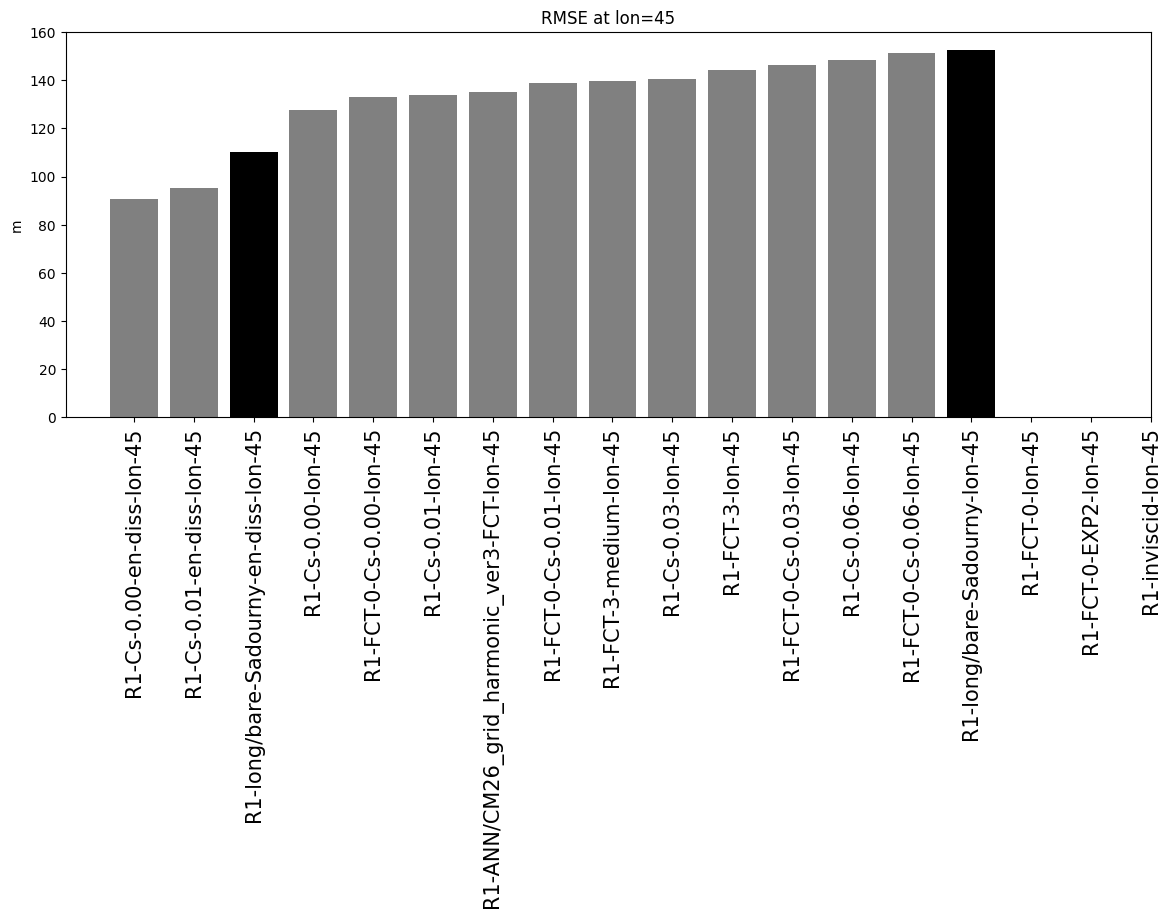

In [10]:
plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-30')
plt.title('RMSE at lon=30')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-45')
plt.title('RMSE at lon=45')

Text(0.5, 1.0, 'RMSE in 3D interface')

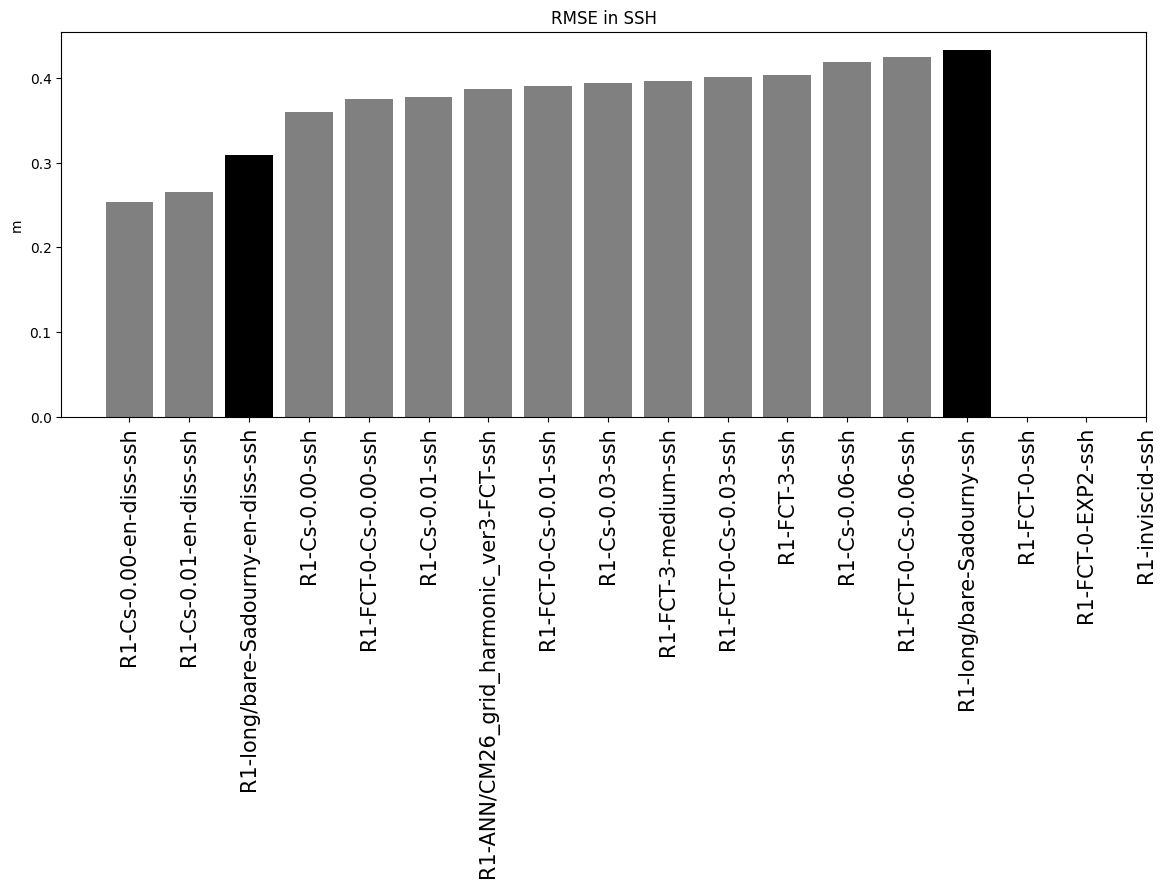

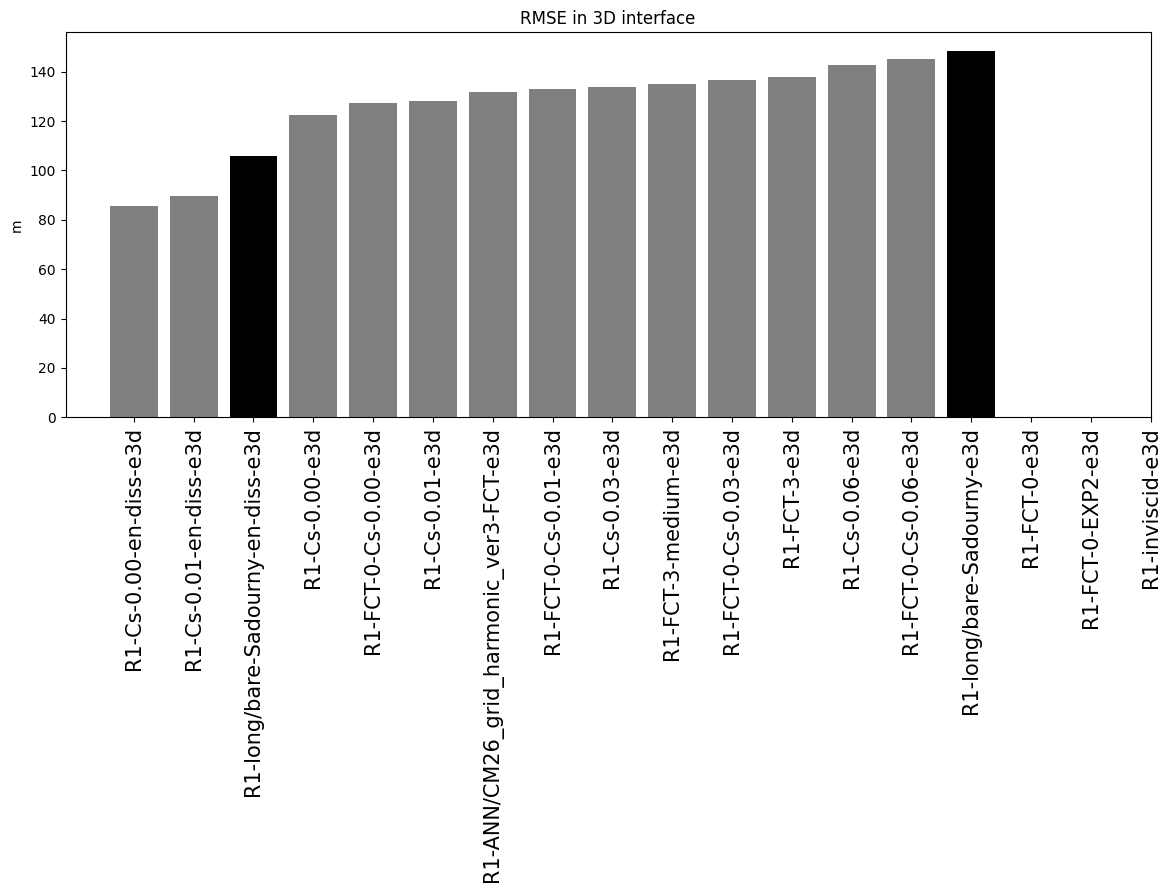

In [11]:
plt.figure(figsize=(14,5))
plot_metrics(RR,'-ssh')
plt.title('RMSE in SSH')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-e3d')
plt.title('RMSE in 3D interface')

# At resolution 1 degress:
* May-16-Cs-0.00 is overall winner
* May-16-FCT-0-Cs-0.00 is second place

Text(0.5, 1.0, 'RMSE at lon=15')

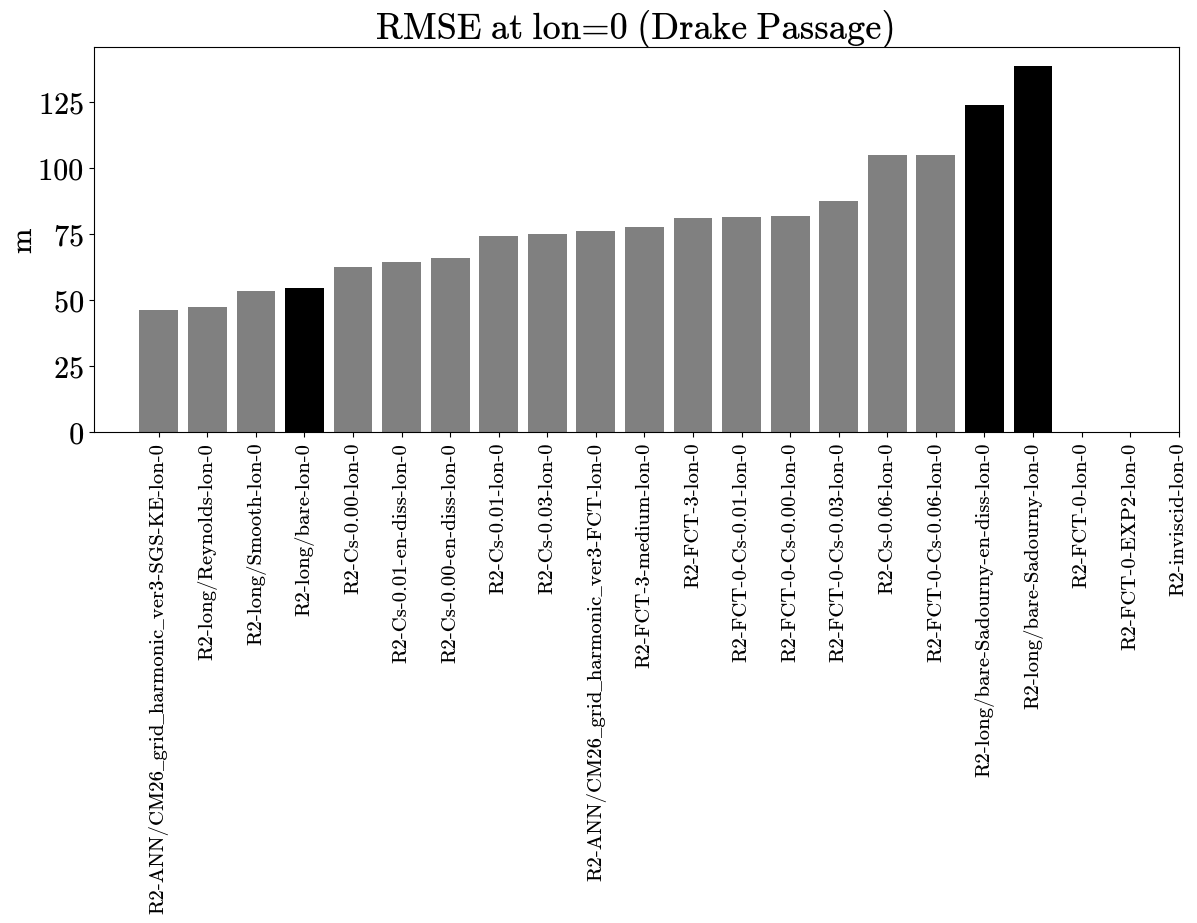

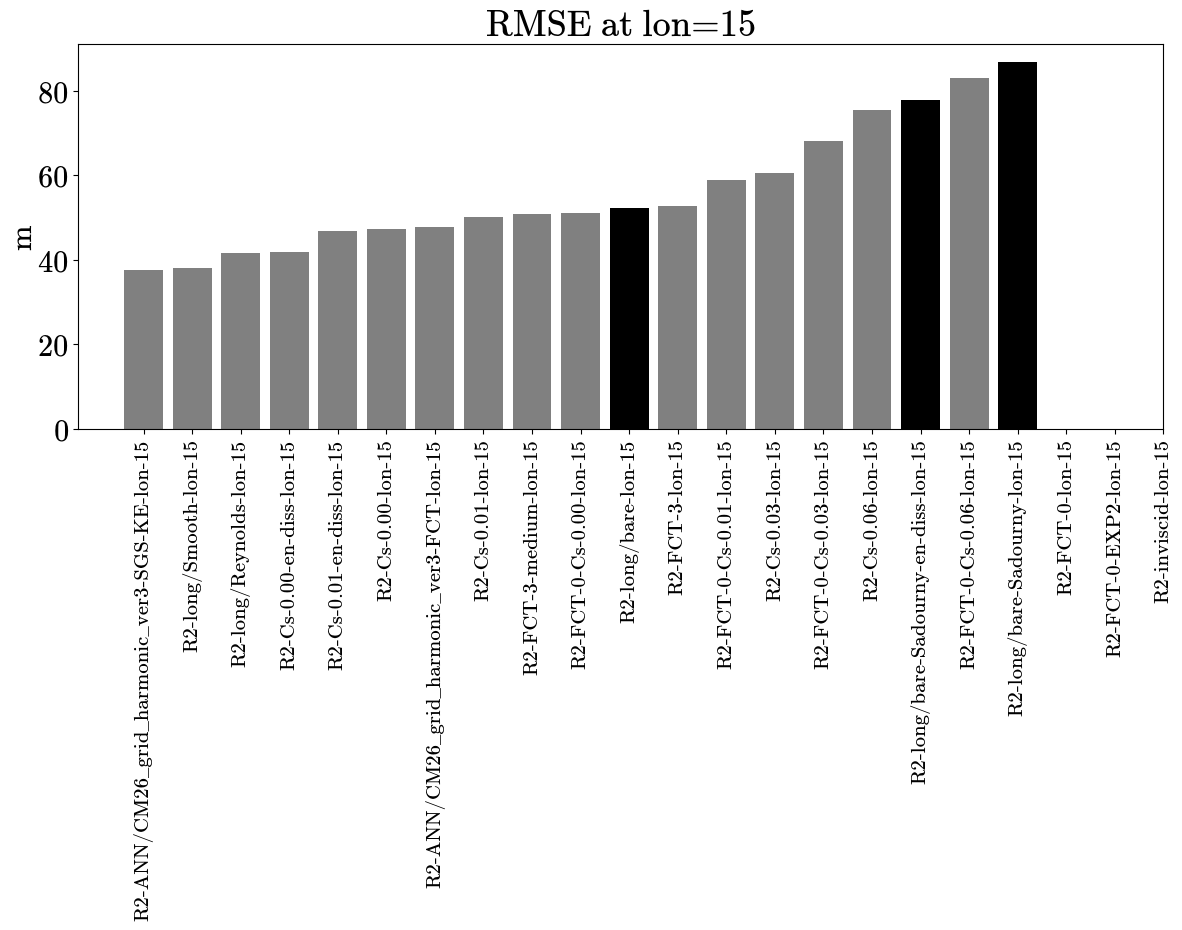

In [18]:
plt.figure(figsize=(14,5))
RR = 'R2'

plot_metrics(RR,'-lon-0')
plt.title('RMSE at lon=0 (Drake Passage)')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-15')
plt.title('RMSE at lon=15')

Text(0.5, 1.0, 'RMSE at lon=45')

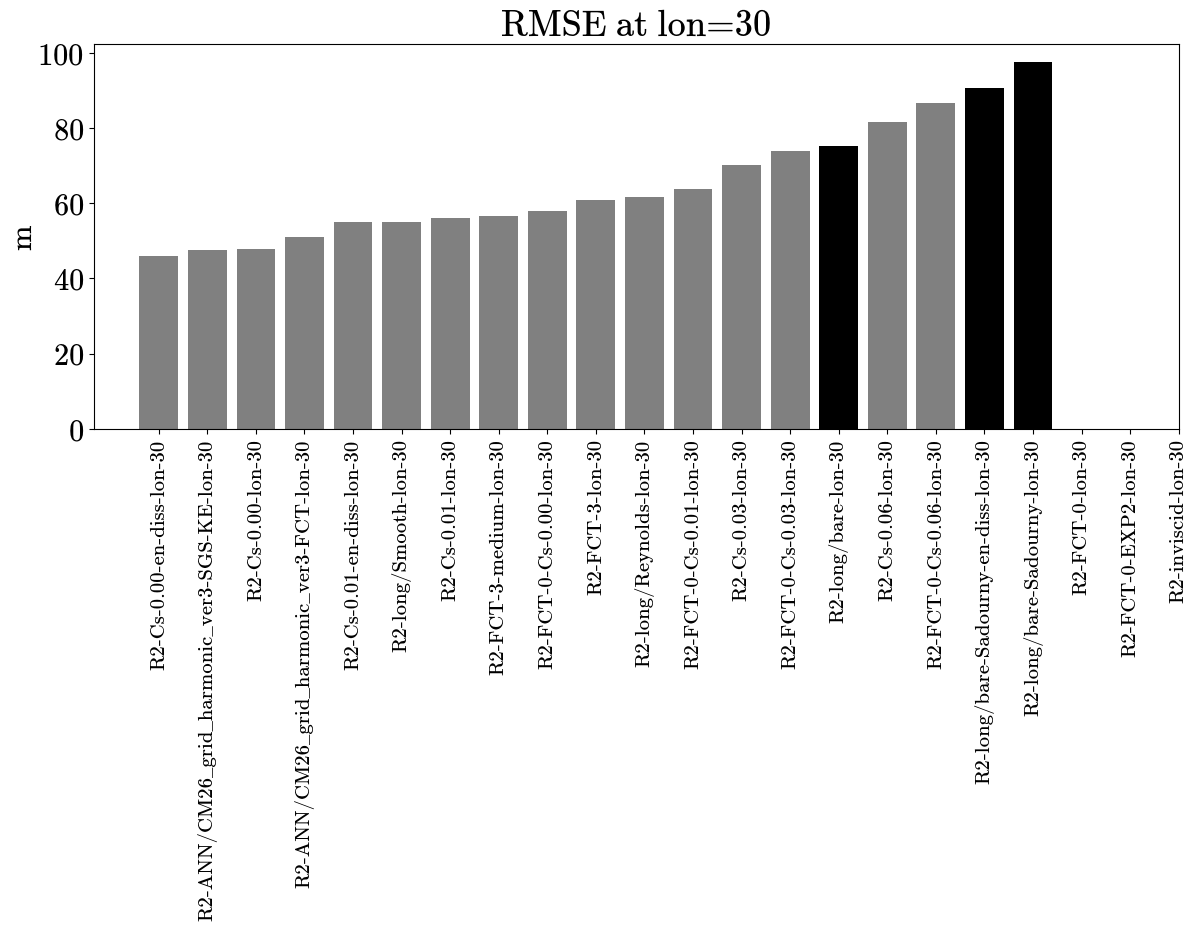

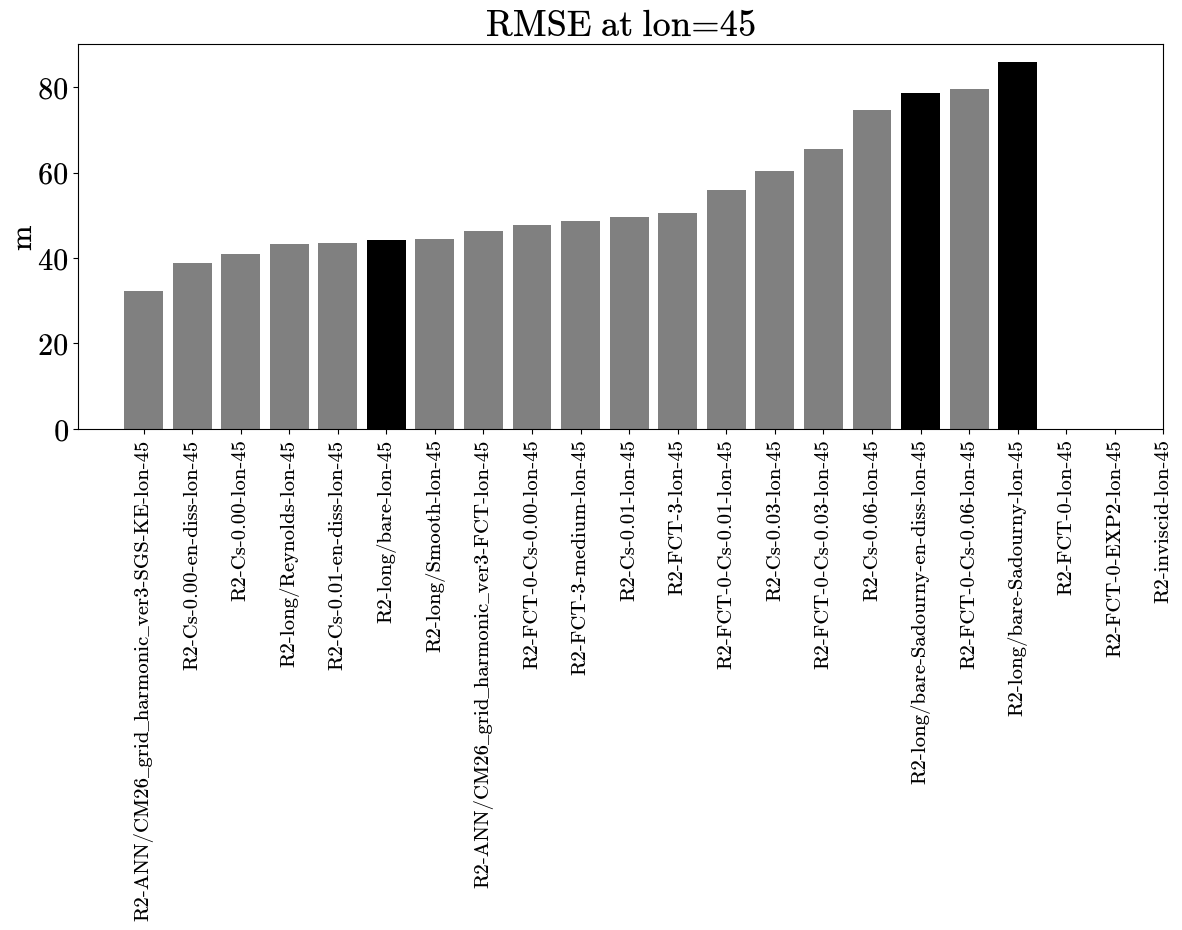

In [19]:
plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-30')
plt.title('RMSE at lon=30')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-45')
plt.title('RMSE at lon=45')


Text(0.5, 1.0, 'RMSE in 3D interface')

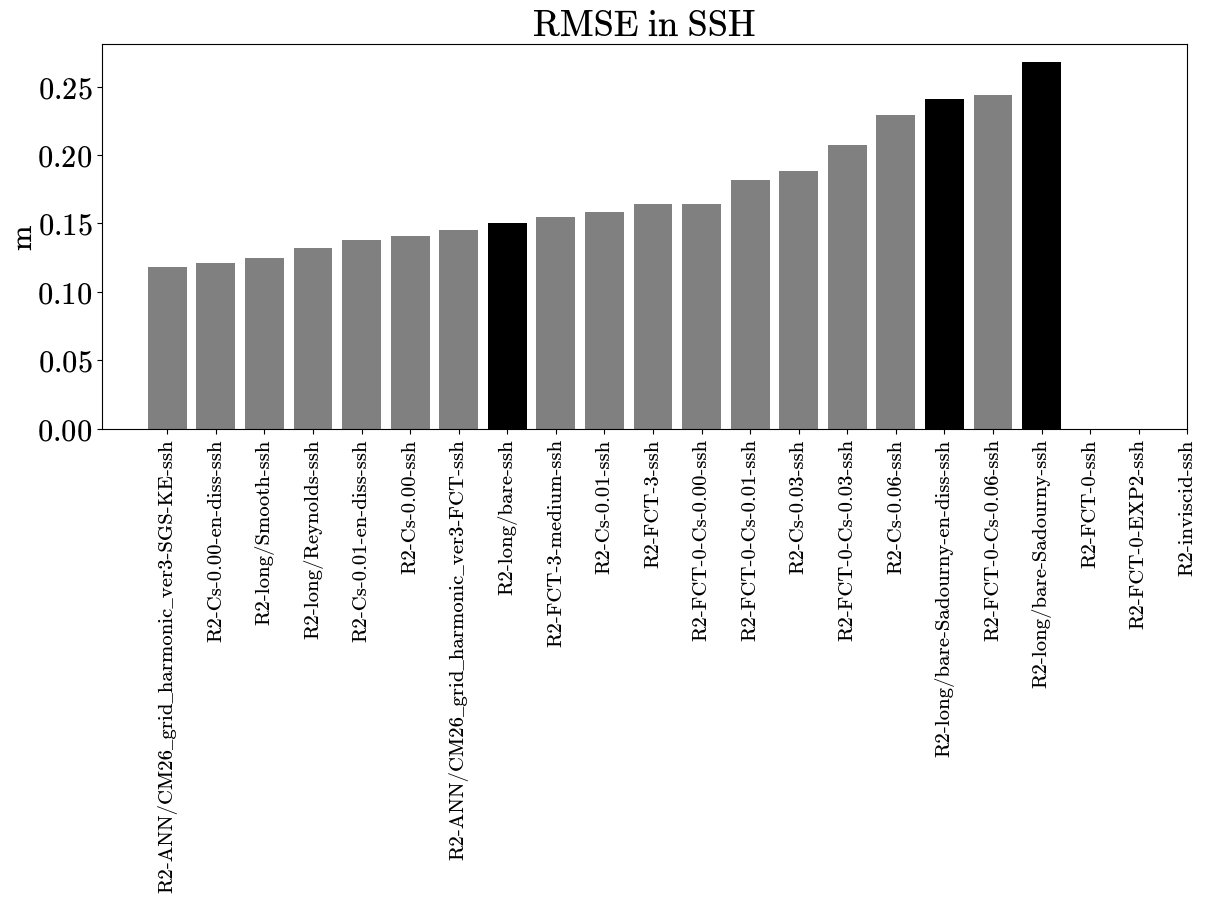

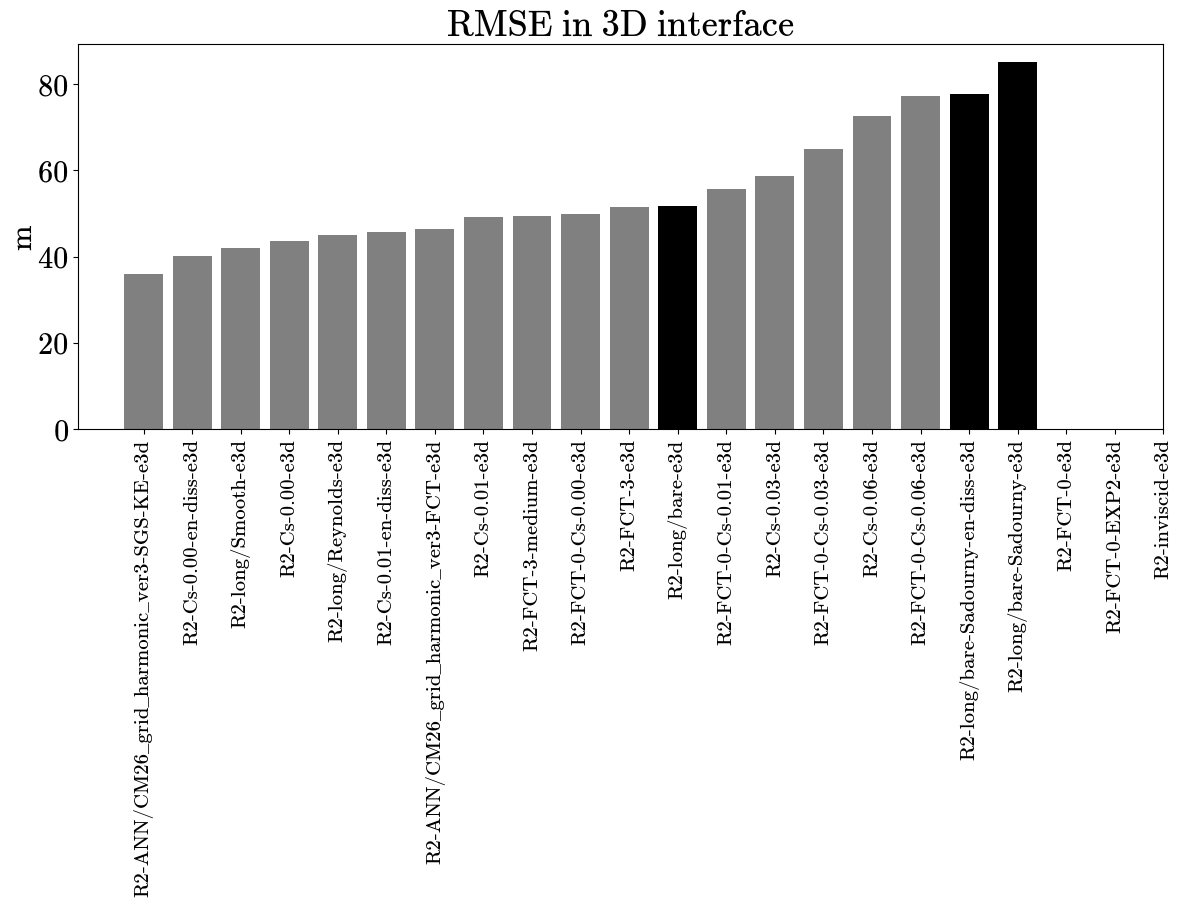

In [20]:
plt.figure(figsize=(14,5))
plot_metrics(RR,'-ssh')
plt.title('RMSE in SSH')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-e3d')
plt.title('RMSE in 3D interface')

# At resolution 1/2 degree:
* The overall winner among new ANNs is again Cs-0.00 model
* Any other diffusion scheme results in drop of performance. with FCT-0-Cs-0.00 is reasonable candidate
* A lot of diffusion deteriorates results
* Another reasonable candidate is CS-0.01

Text(0.5, 1.0, 'RMSE at lon=15')

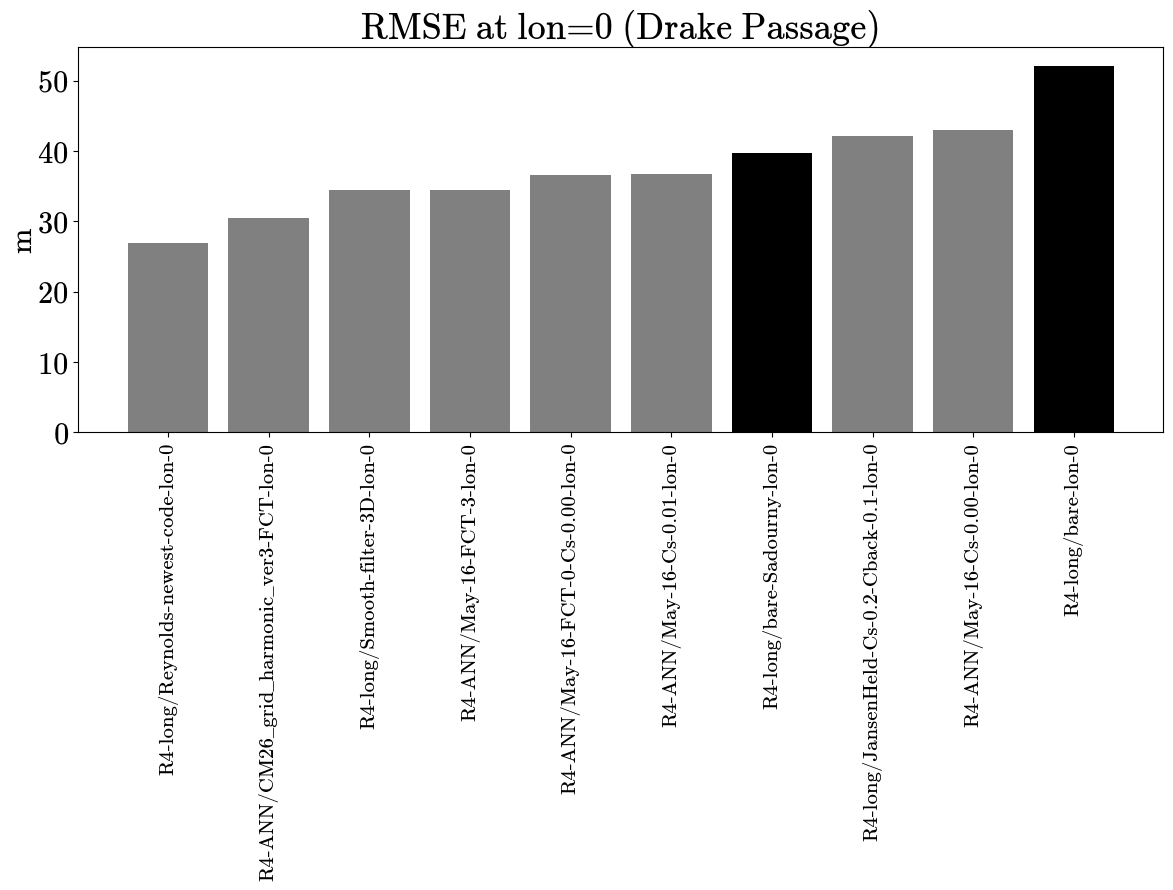

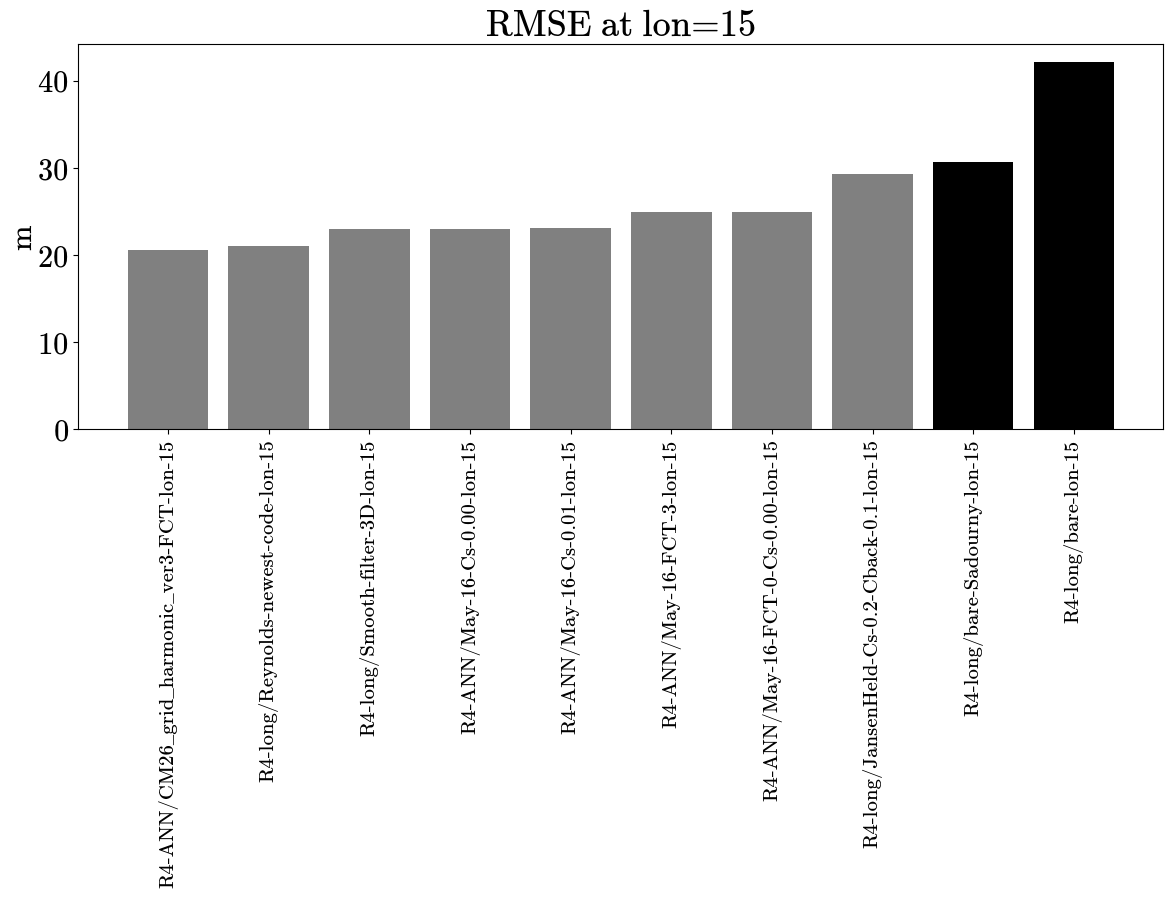

In [21]:
plt.figure(figsize=(14,5))
RR = 'R4'

plot_metrics(RR,'-lon-0')
plt.title('RMSE at lon=0 (Drake Passage)')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-15')
plt.title('RMSE at lon=15')

Text(0.5, 1.0, 'RMSE at lon=45')

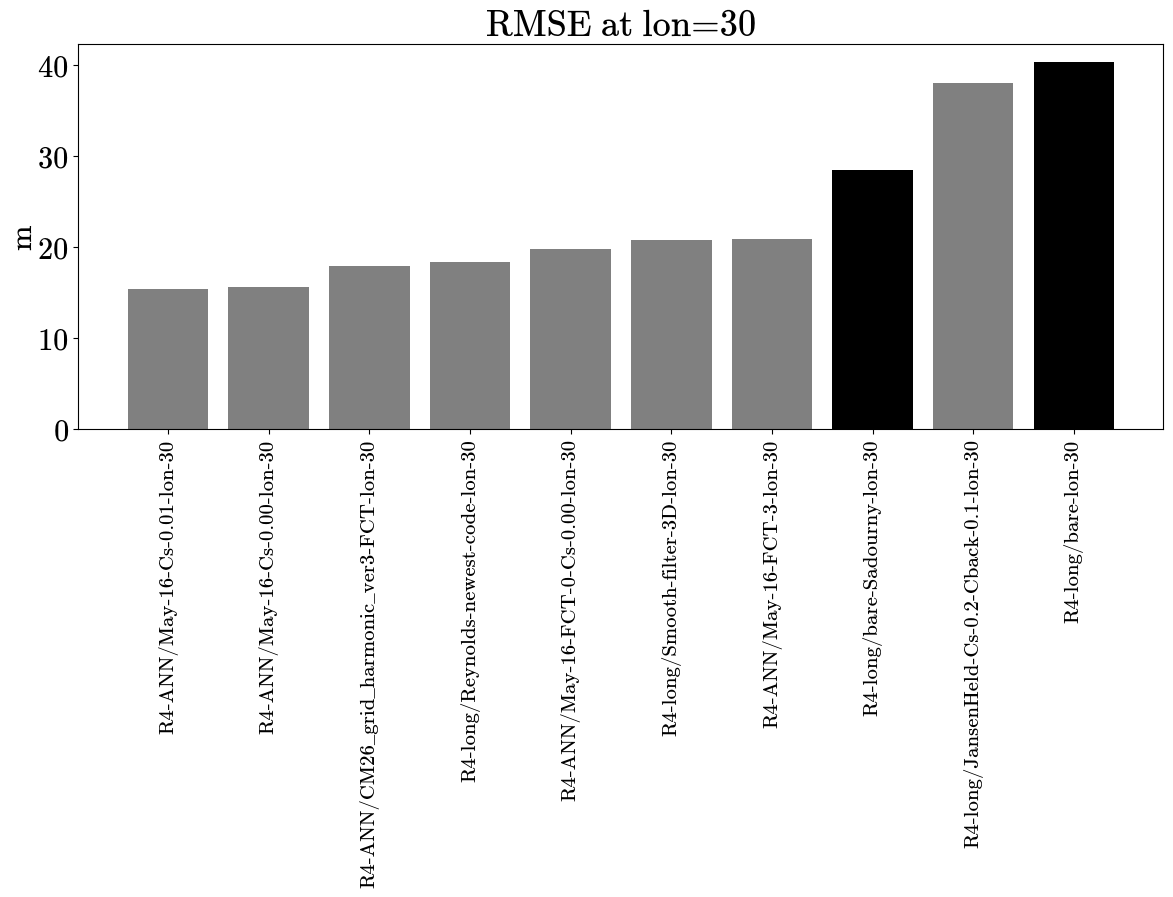

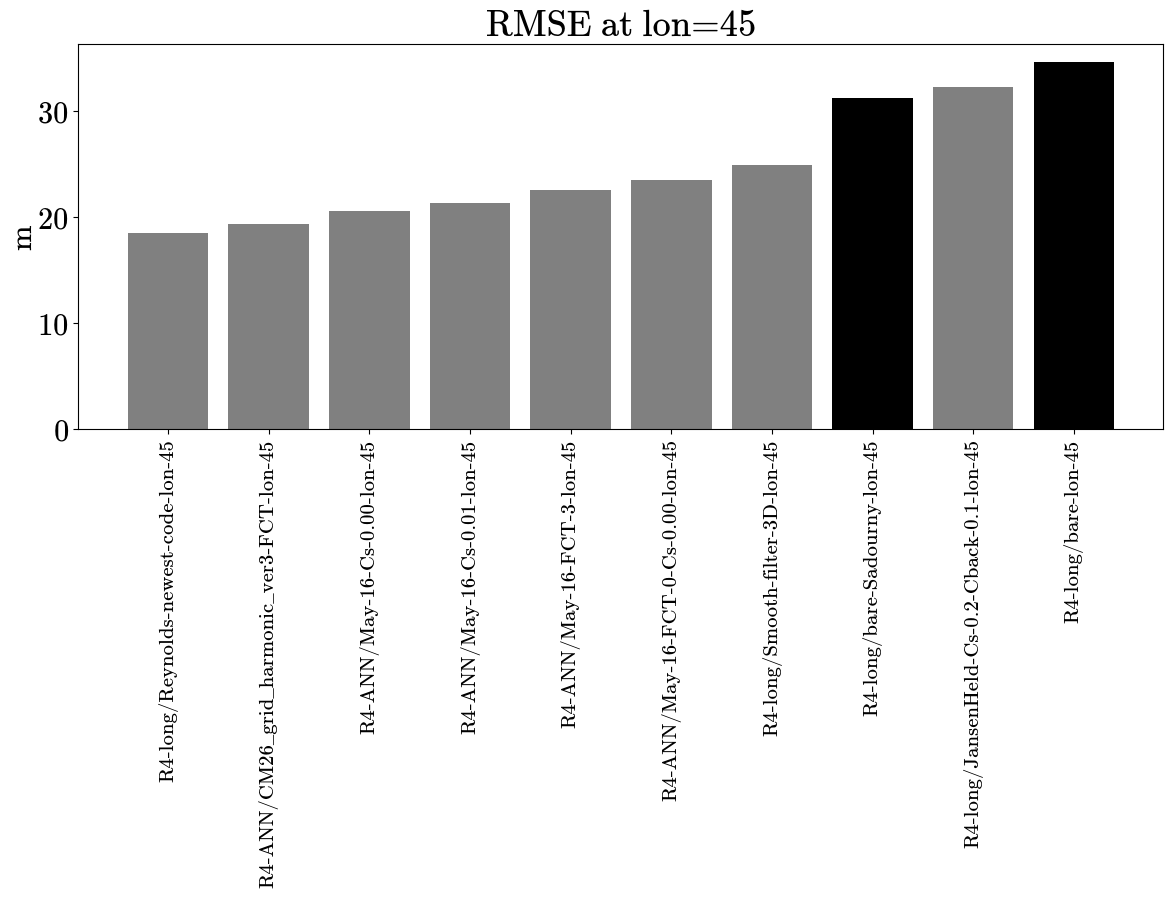

In [24]:
plt.figure(figsize=(14,5))
RR = 'R4'

plot_metrics(RR,'-lon-30')
plt.title('RMSE at lon=30')

plt.figure(figsize=(14,5))
plot_metrics(RR,'-lon-45')
plt.title('RMSE at lon=45')

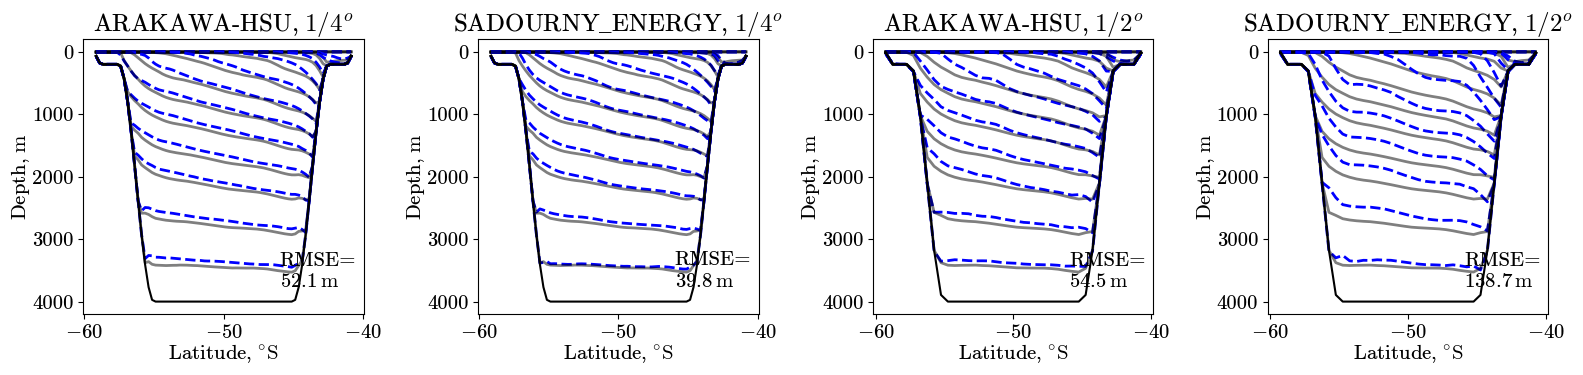

In [46]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 15})
plt.figure(figsize=(16,4))
kw = {'lon': 0, 'lat_max': None}
plt.subplot(1,4,1)
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('ARAKAWA-HSU, $1/4^o$')
plt.subplot(1,4,2)
plot_interfaces(*interfaces('R4-long/bare-Sadourny', **kw))
plt.title('SADOURNY_ENERGY, $1/4^o$')

plt.subplot(1,4,3)
plot_interfaces(*interfaces('R2-long/bare', **kw))
plt.title('ARAKAWA-HSU, $1/2^o$')
plt.subplot(1,4,4)
plot_interfaces(*interfaces('R2-long/bare-Sadourny', **kw))
plt.title('SADOURNY_ENERGY, $1/2^o$')

plt.tight_layout()

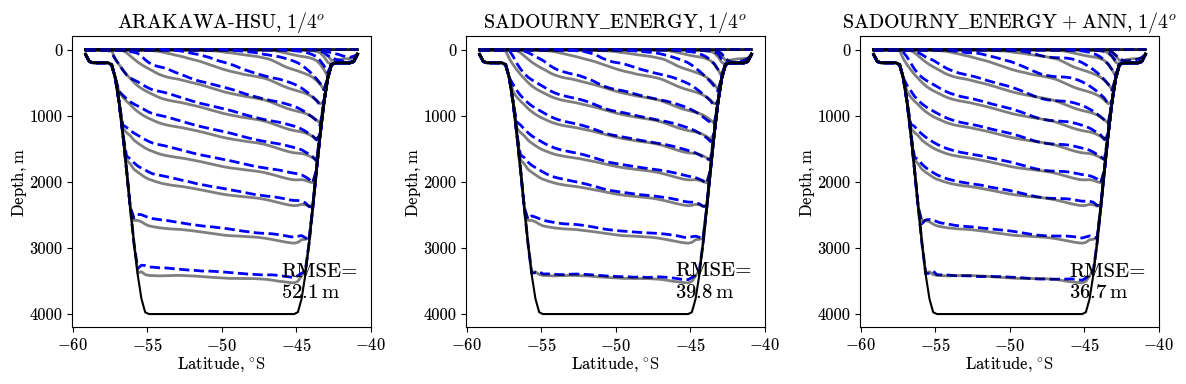

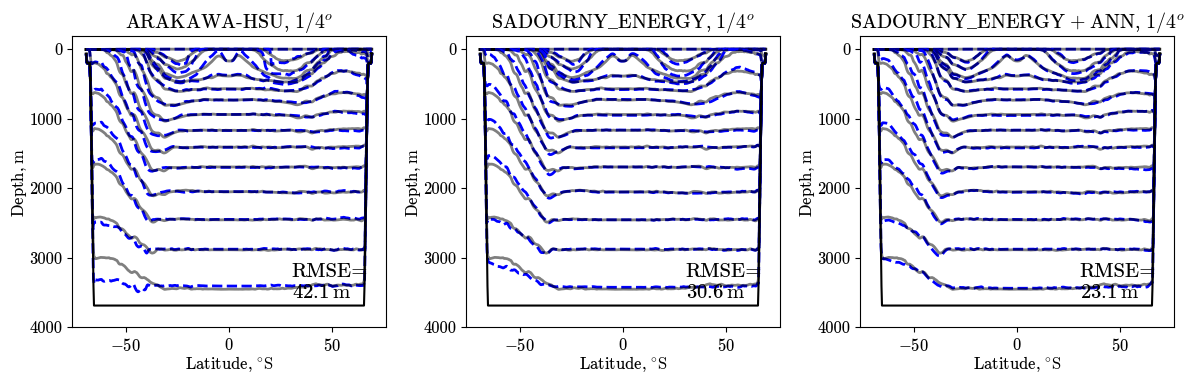

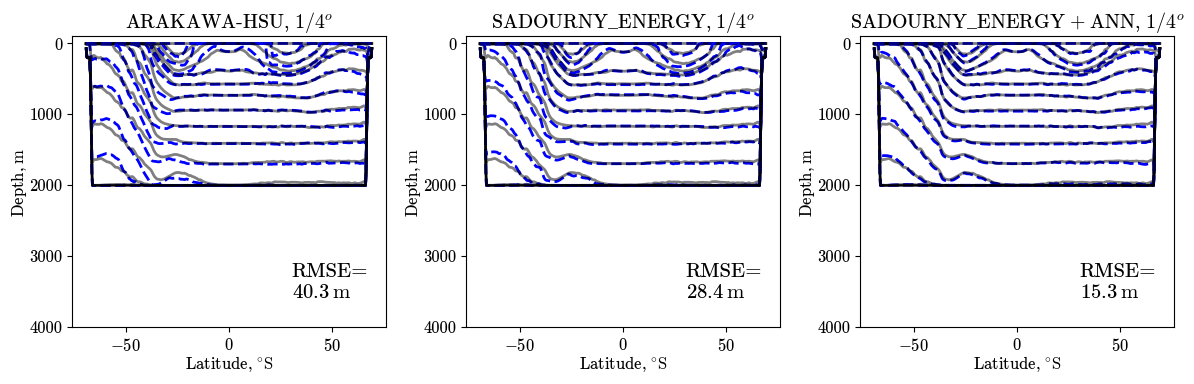

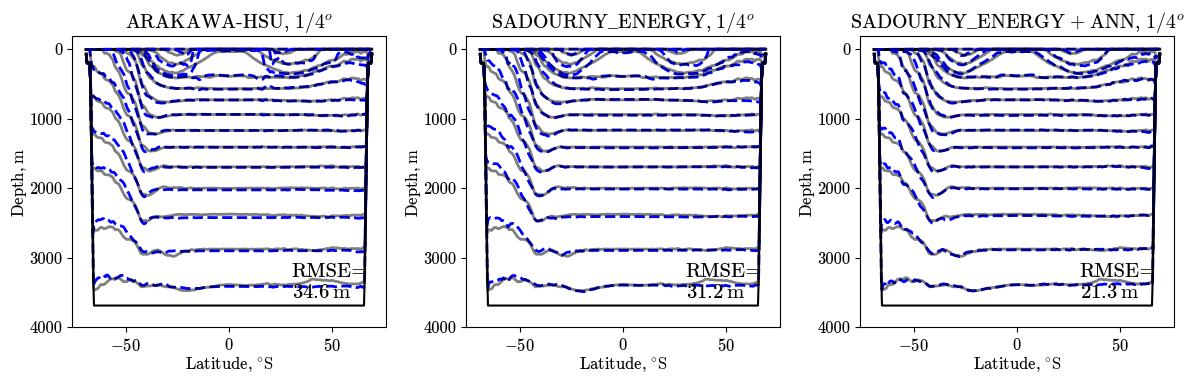

In [62]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 12})
for lon in [0,15,30,45]:
    plt.figure(figsize=(12,4))
    kw = {'lon': lon, 'lat_max': None}
    plt.subplot(1,3,1)
    plot_interfaces(*interfaces('R4-long/bare', **kw))
    plt.title('ARAKAWA-HSU, $1/4^o$')
    plt.subplot(1,3,2)
    plot_interfaces(*interfaces('R4-long/bare-Sadourny', **kw))
    plt.title('SADOURNY_ENERGY, $1/4^o$')
    
    plt.subplot(1,3,3)
    plot_interfaces(*interfaces('R4-ANN/May-16-Cs-0.01', **kw))
    plt.title('SADOURNY_ENERGY + ANN, $1/4^o$')
    
    plt.tight_layout()

Text(0.5, 1.0, 'RMSE in 3D interface')

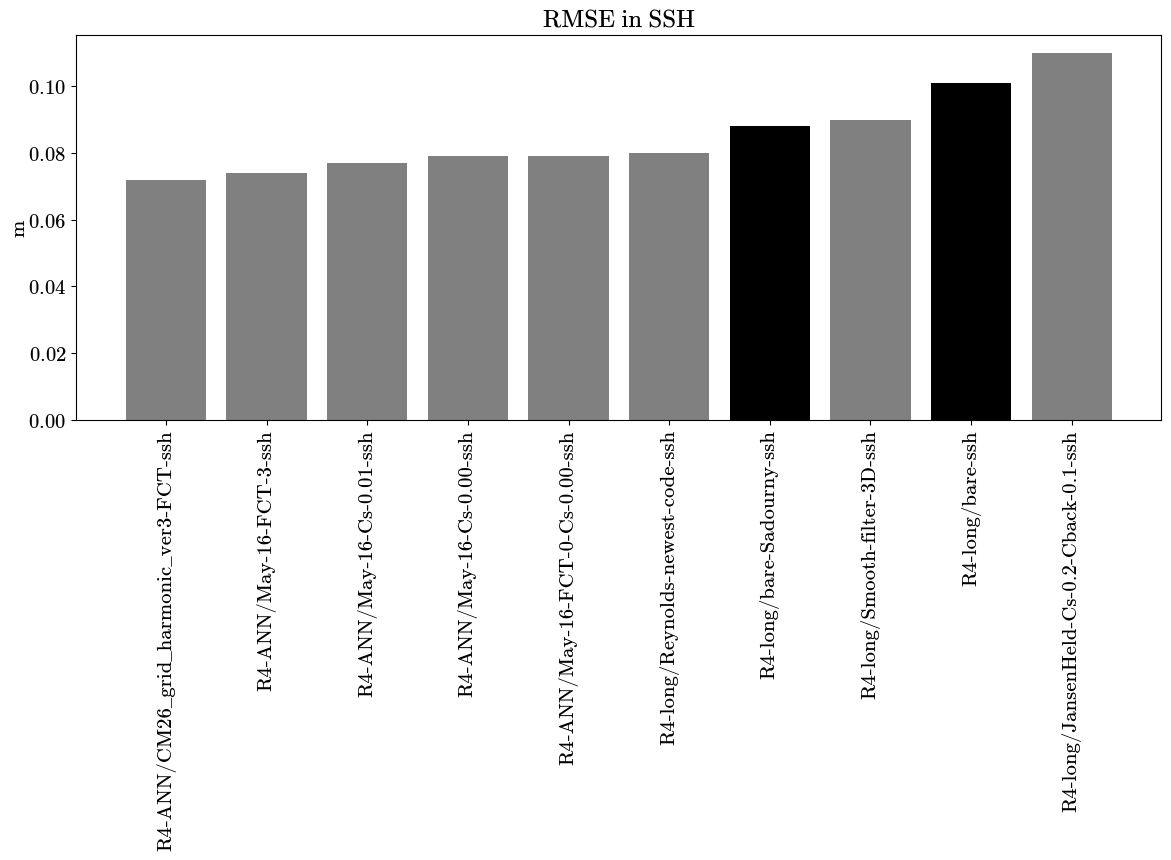

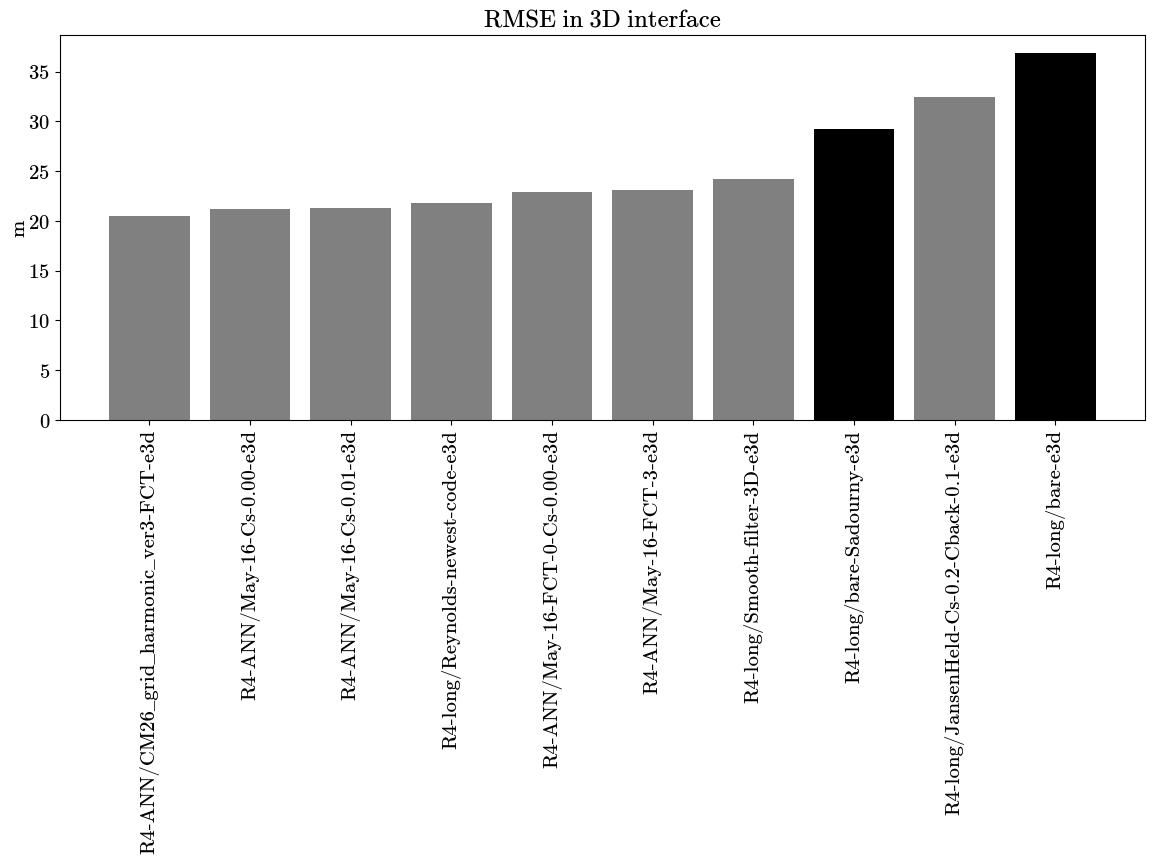

In [47]:
plt.figure(figsize=(14,5))
plot_metrics('R4','-ssh')
plt.title('RMSE in SSH')

plt.figure(figsize=(14,5))
plot_metrics('R4','-e')
plt.title('RMSE in 3D interface')

In [48]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
def plot_timeseries(exps=['R1-long/bare-0.2-Sadourny'], tmax=30000):
    plt.figure(figsize=(10,10))
    for exp in exps:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/ocean.stats.nc', decode_times=False)
        except:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/ocean.stats.nc', decode_times=False)
        plt.subplot(3,1,1)
        ds.max_CFL_lin.plot()
        plt.xlabel('Days')
        ticks = [0,int(tmax/3),int(tmax*2/3),int(tmax)]
        plt.xticks(ticks,ticks)
        plt.xlim([0,tmax])

        plt.subplot(3,1,2)
        (ds.KE.sum('Layer')).plot()
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        plt.axhline(y=2.45e+18, color='k')
        plt.xlim([0,tmax])

        plt.subplot(3,1,3)
        (ds.APE.sum('Interface')).plot(label=exp)
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        plt.axhline(y=0.958e+20, color='k')
        plt.xlim([0,tmax])
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1,1))

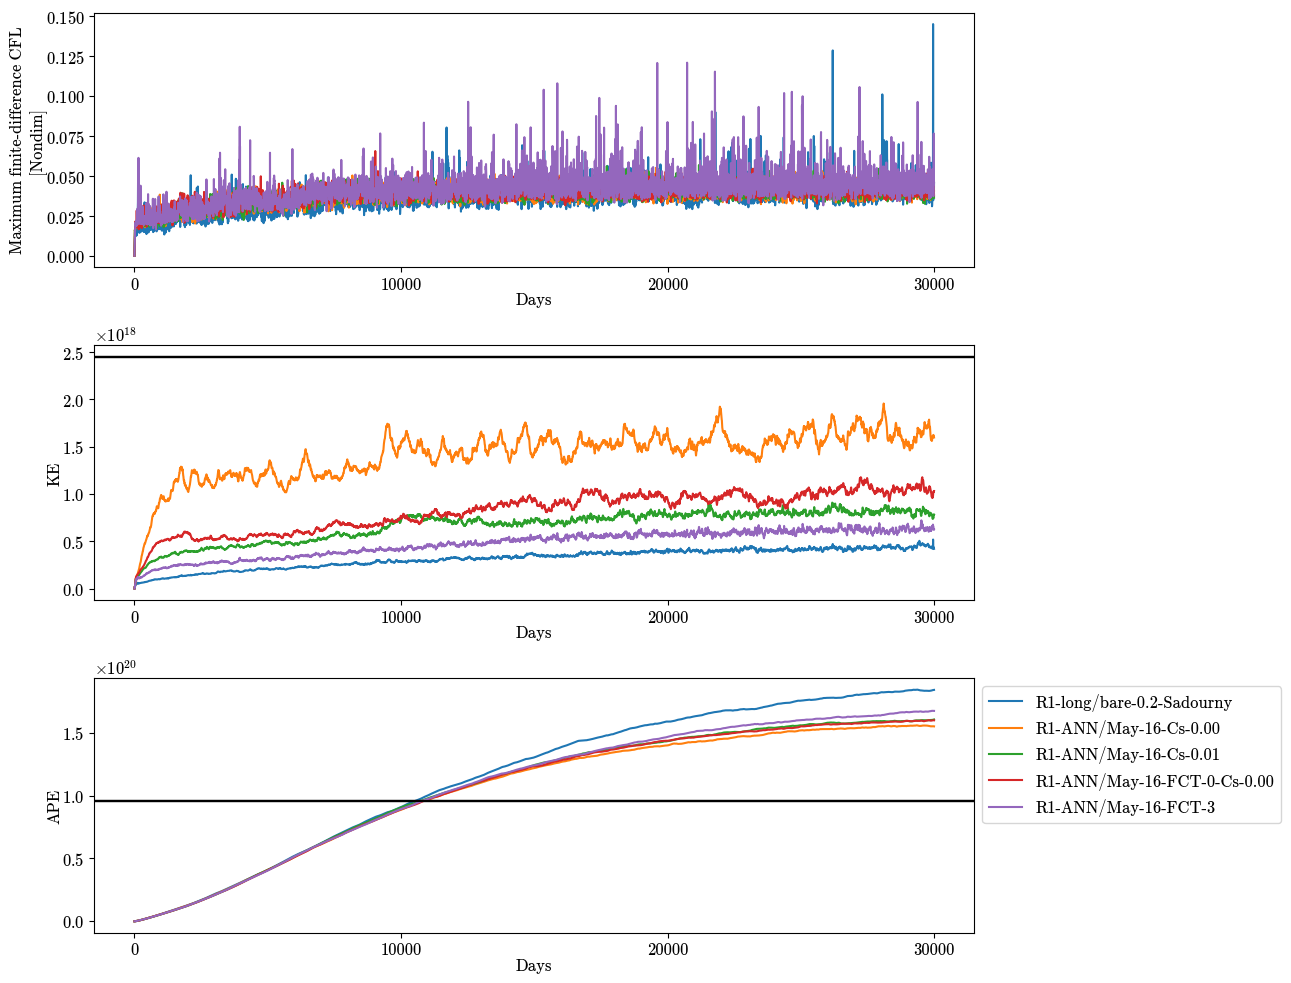

In [4]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-0.2-Sadourny', 'R1-ANN/May-16-Cs-0.00', 'R1-ANN/May-16-Cs-0.01', 'R1-ANN/May-16-FCT-0-Cs-0.00', 'R1-ANN/May-16-FCT-3'])

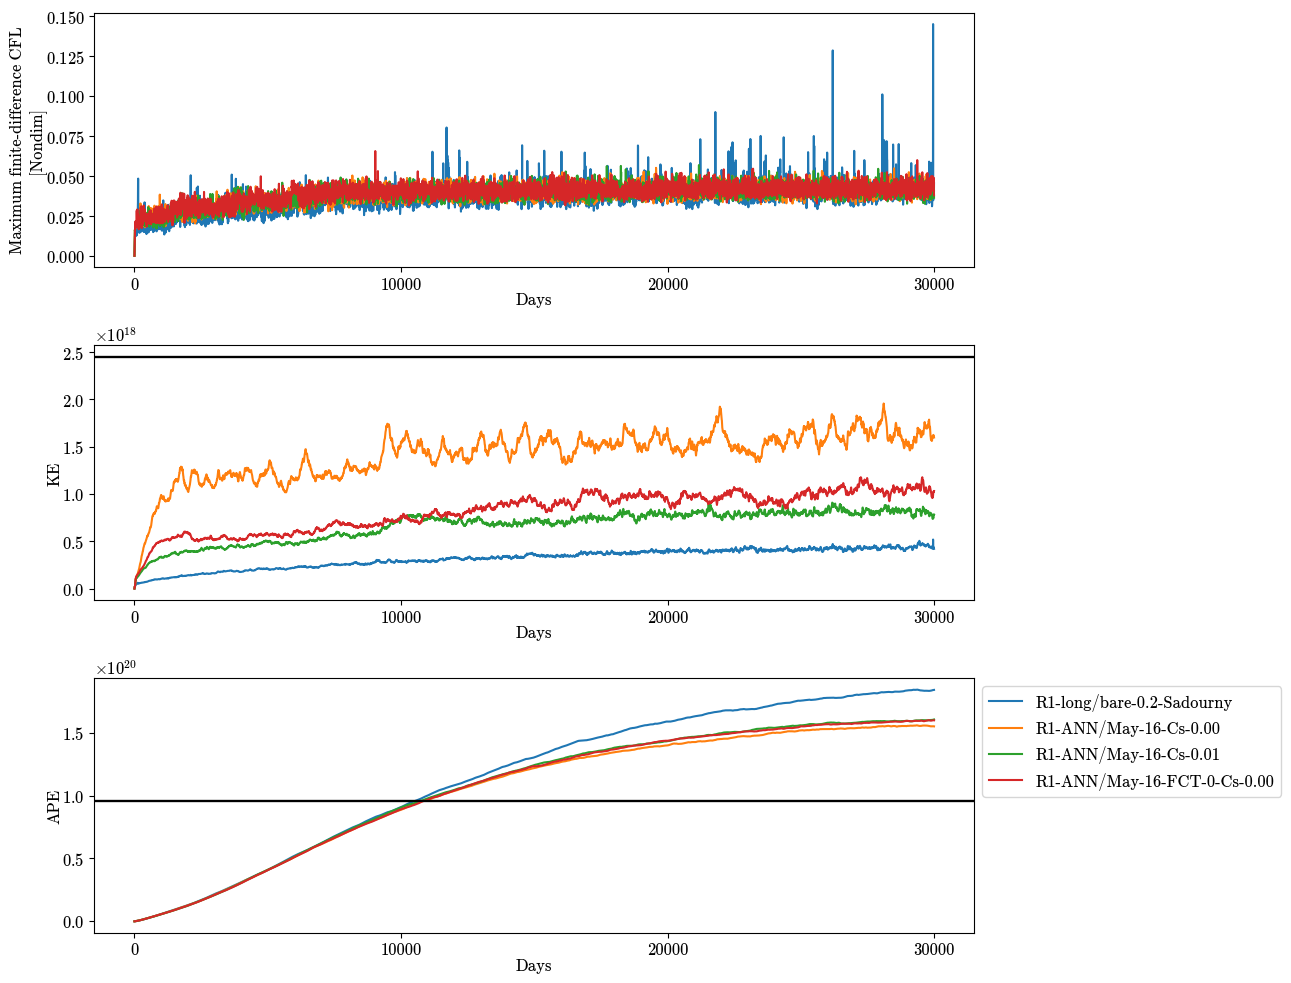

In [239]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-0.2-Sadourny', 'R1-ANN/May-16-Cs-0.00', 'R1-ANN/May-16-Cs-0.01', 'R1-ANN/May-16-FCT-0-Cs-0.00'])

# At resolution 1 degree
* FCT-3 overshoots in CFL. So we do not consider it
* CS=0.00, CS=0.01 and FCT-0-Cs-0.0 are OK in CFL, all having similar problems with not too much energy
* Energy of Cs=0.00 is relatively large for such coarse resolution
* FCT-0 along has overshoots in CFL and 

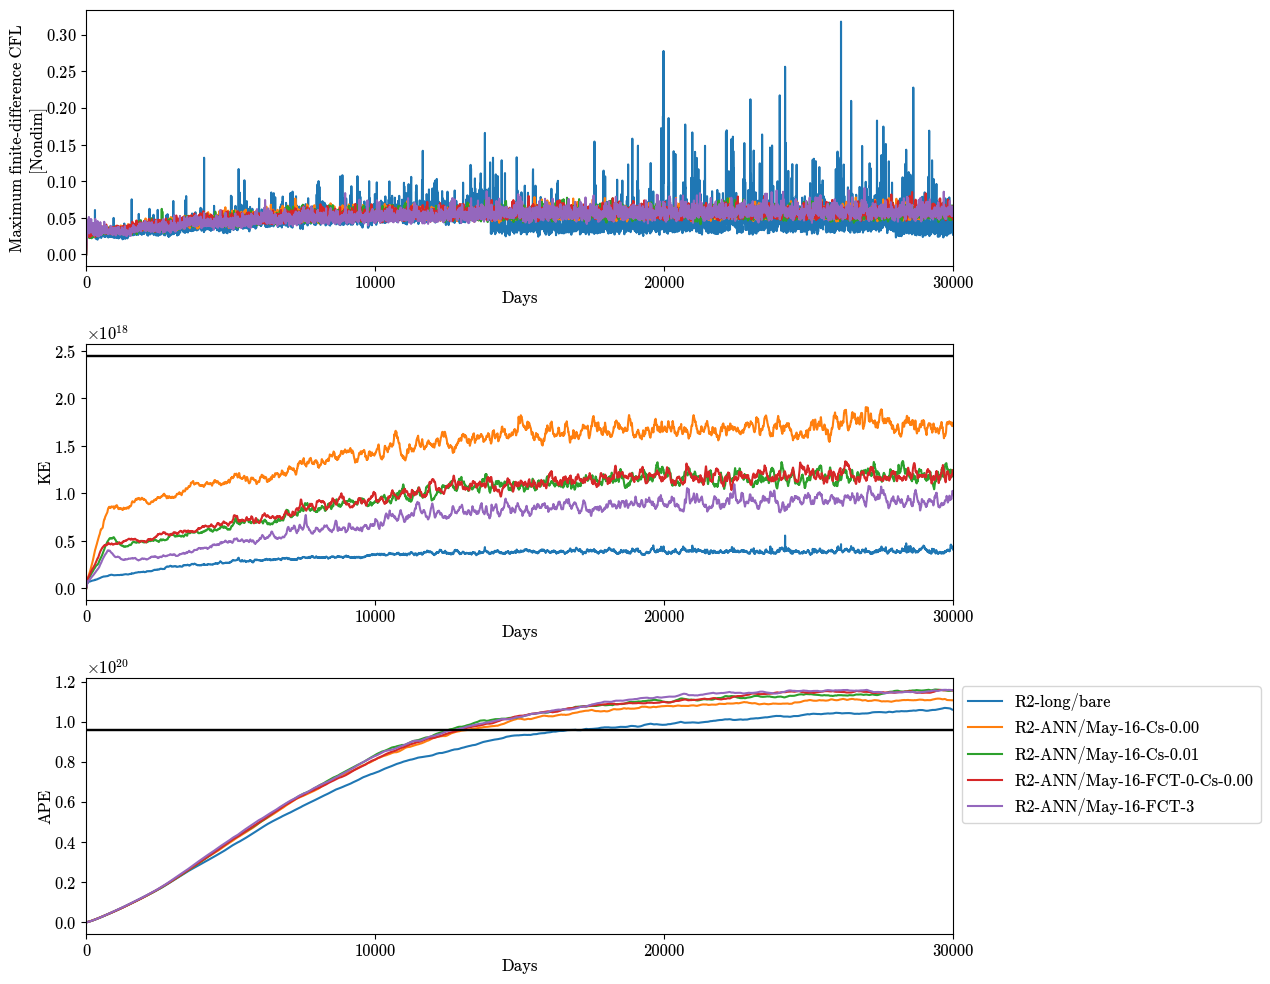

In [5]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R2-long/bare', 
                 'R2-ANN/May-16-Cs-0.00', 'R2-ANN/May-16-Cs-0.01', 'R2-ANN/May-16-FCT-0-Cs-0.00', 
                 'R2-ANN/May-16-FCT-3'])

# Summary at resolution 1/2
* There are no overshoots in CFL for any ANN limiter/viscosity
* FCT-0+Cs-0.00 and Cs-0.01 are almost identical
* Cs-0.00 is overall winner in terms of energy and APE

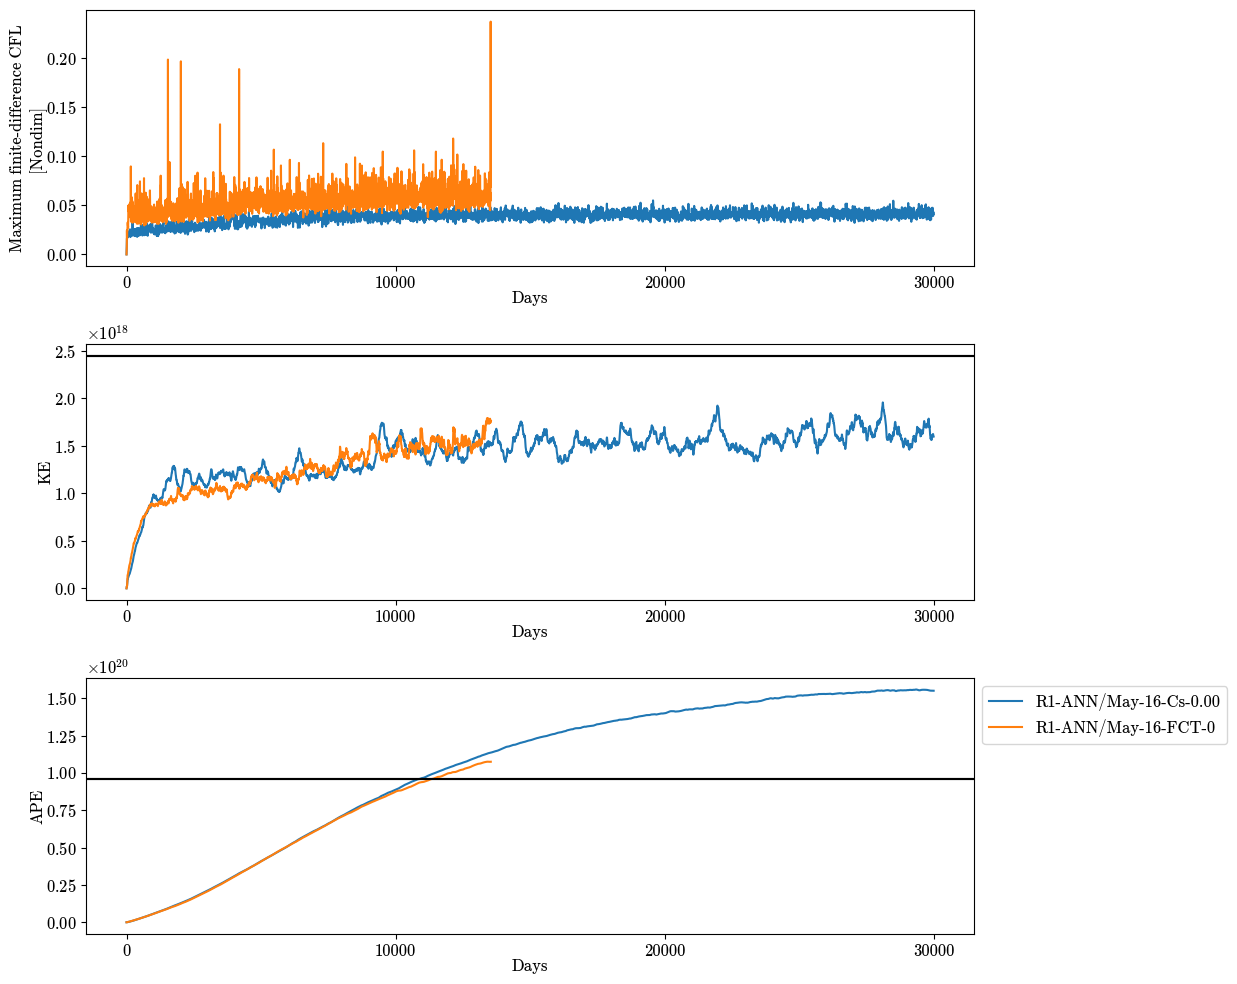

In [252]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-ANN/May-16-Cs-0.00','R1-ANN/May-16-FCT-0'])

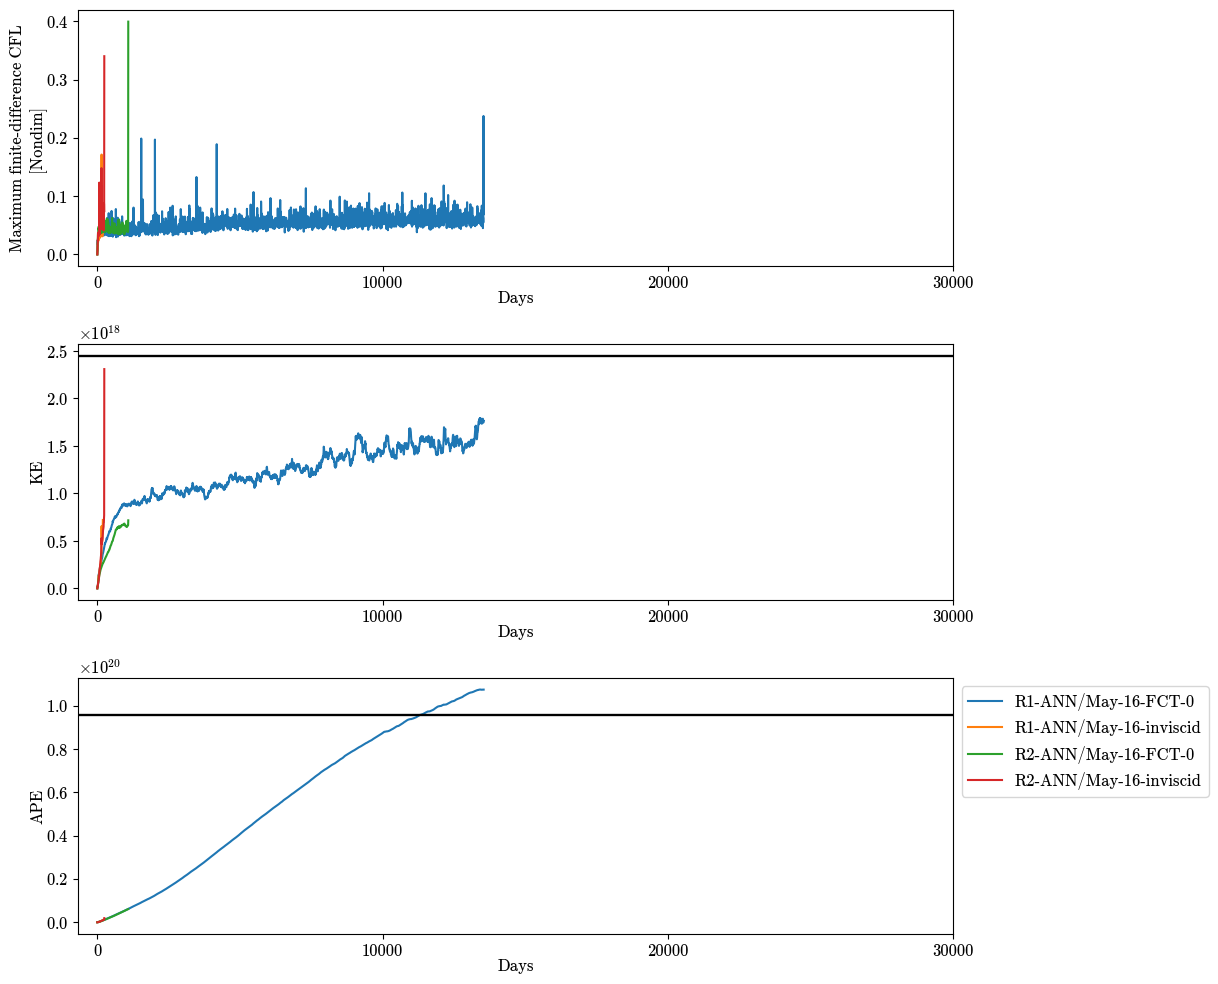

In [5]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-ANN/May-16-FCT-0', 'R1-ANN/May-16-inviscid', 'R2-ANN/May-16-FCT-0', 'R2-ANN/May-16-inviscid'])

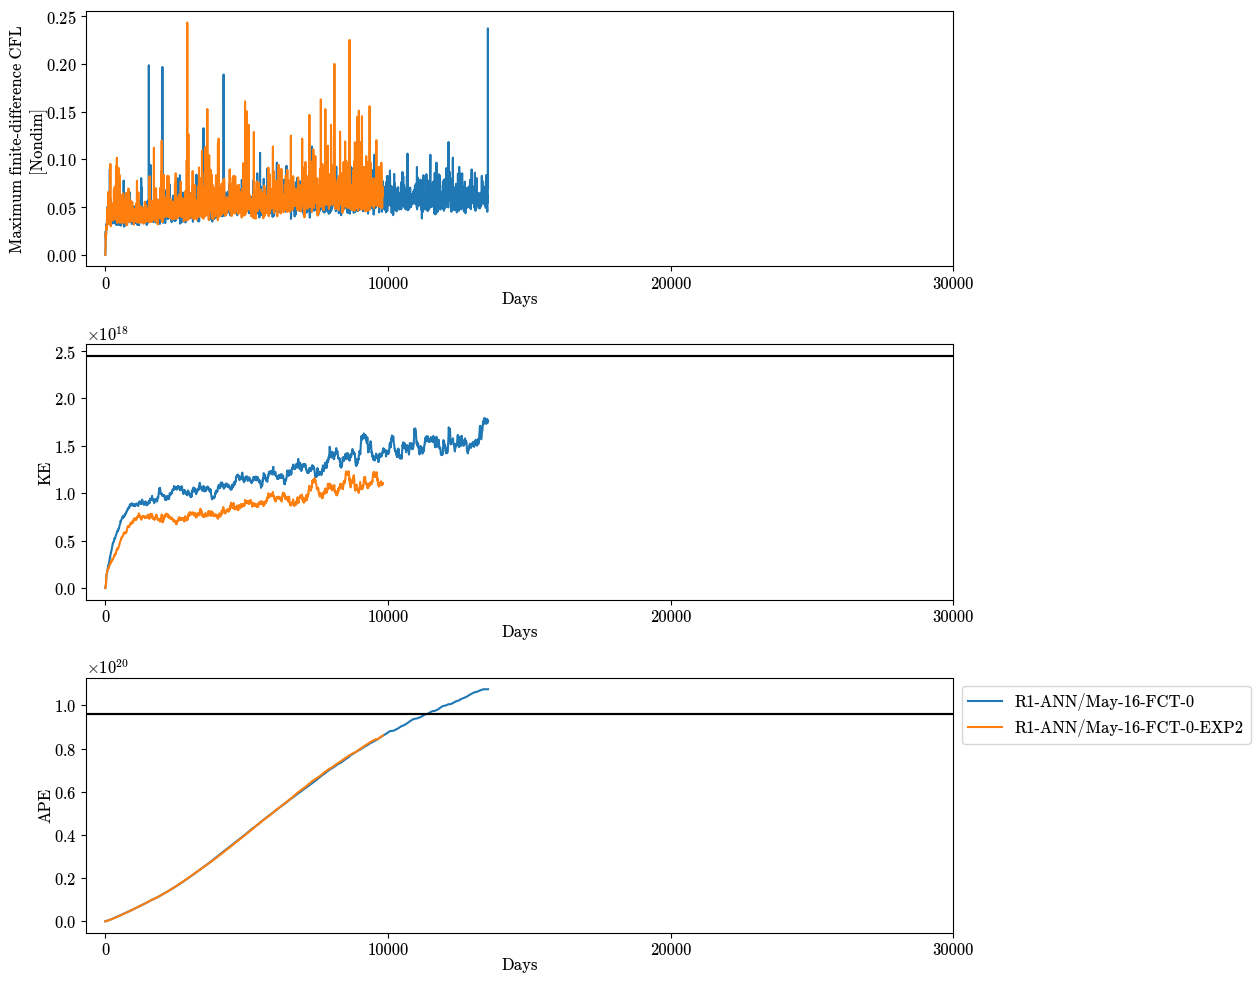

In [7]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-ANN/May-16-FCT-0', 'R1-ANN/May-16-FCT-0-EXP2'])

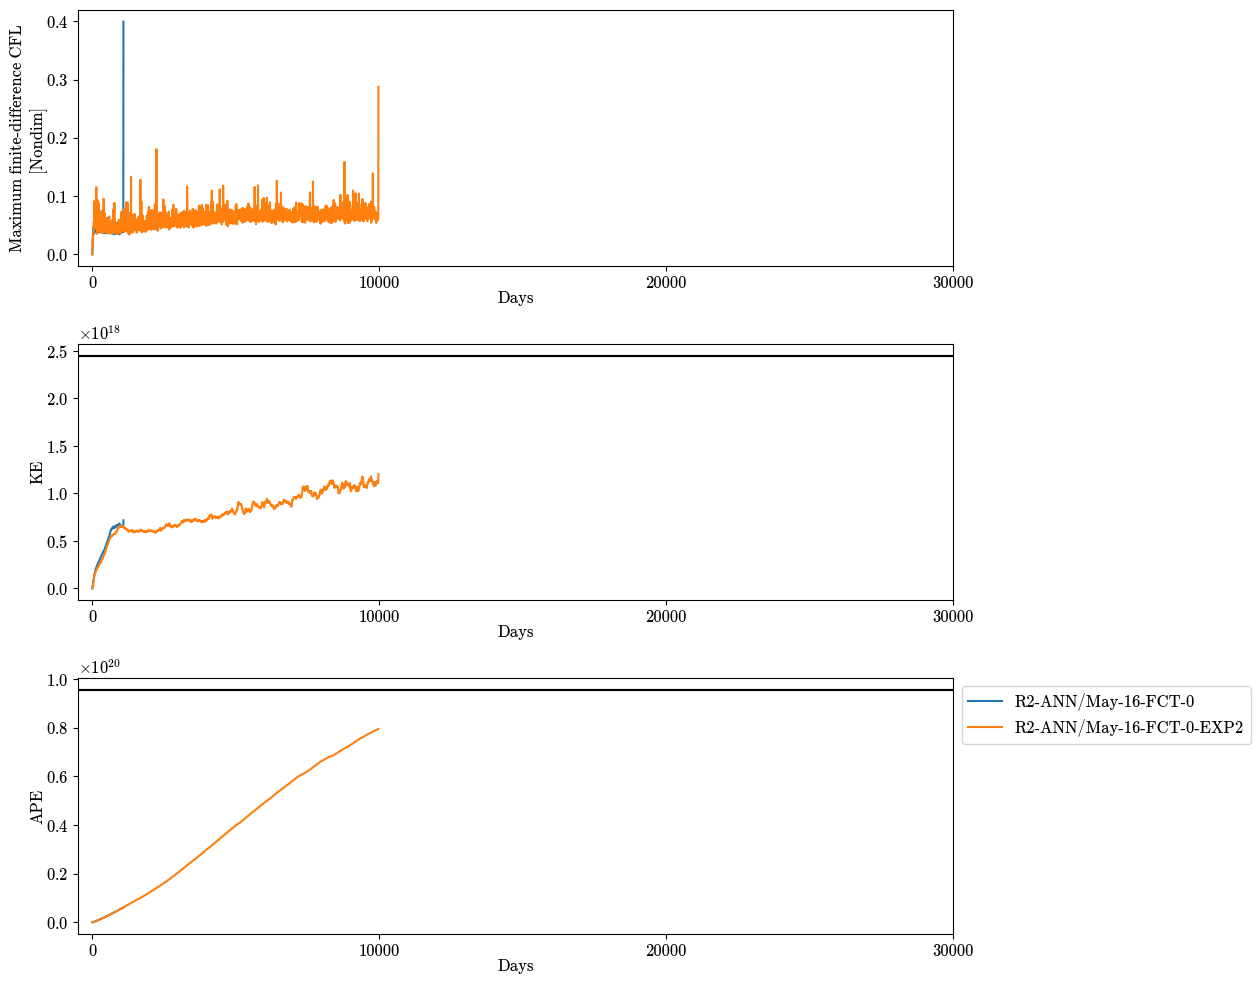

In [8]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R2-ANN/May-16-FCT-0', 'R2-ANN/May-16-FCT-0-EXP2'])

* FCT-0 has higher CFL than competitors at the same energy, and thus is less efficient technique to make computations stable as compared to smagorinsky eddy viscosity
* Still FCT-0 is better than inviscid fluid
* EXP2 does not seem to be much better in terms of physics or overshoots in CFL

# Overall Summary:
FCT-0-Cs-0.00, Cs-0.00 and Cs-0.01 are very stable models with good characteristics. However, it is unclear which one out of three is the best in NW2-R4. This remains to be evaluated. Apart from higher energy of CS-0.00, video and CFL do not show significant numerical issues for all of them at resolution 1/2 and 1 degrees.

Because FCT-3 is completely different limiting technique, it also can be considered as an option.

# R4 simulations

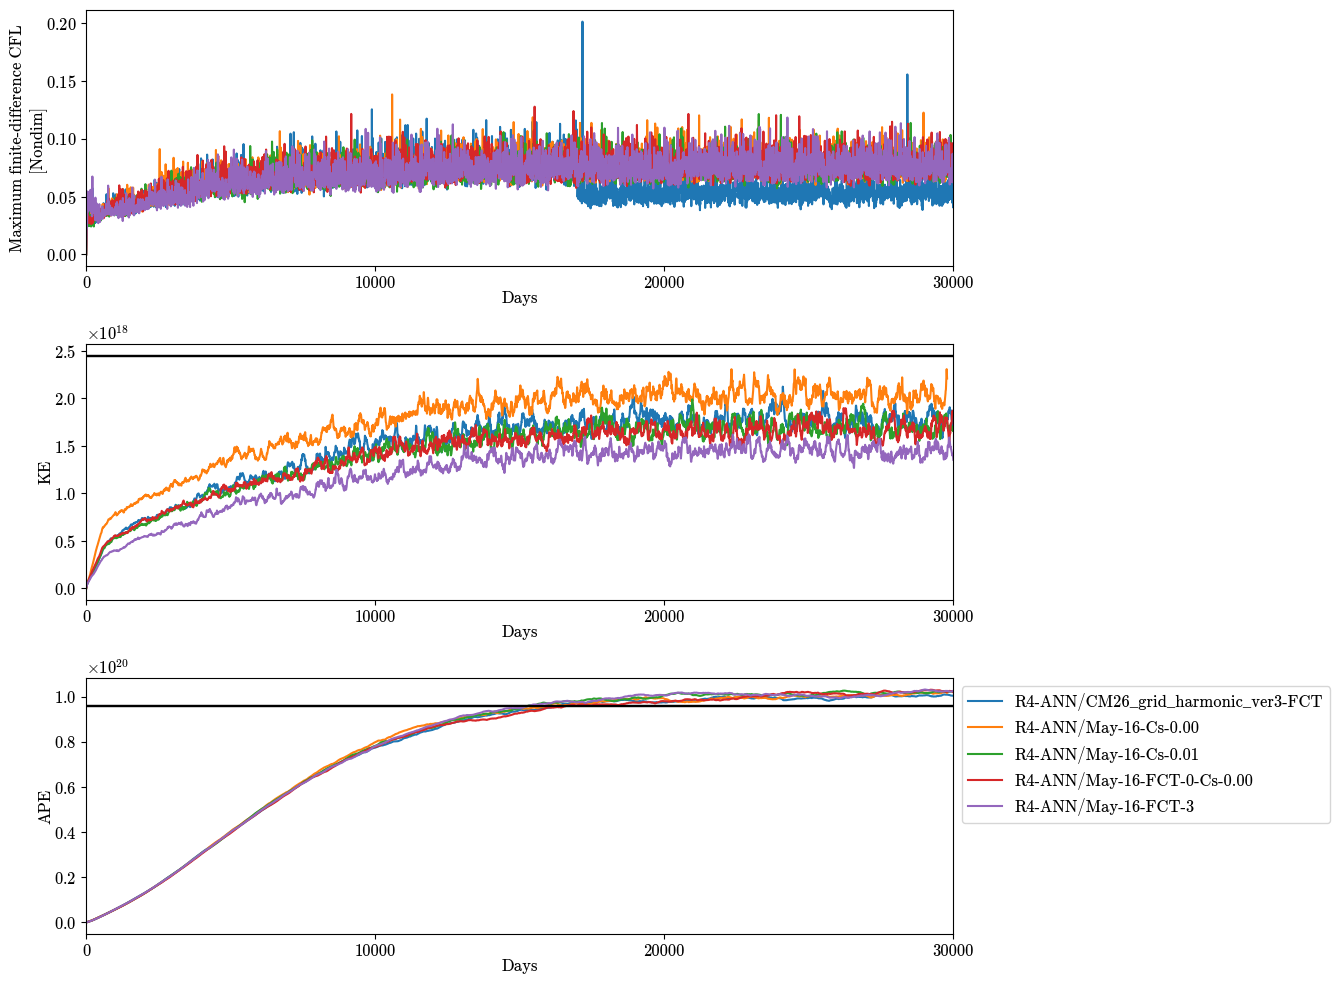

In [43]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries([
                 #'R4-long/bare',
                 #'R4-ANN/May-16-FCT-0', 
                 'R4-ANN/CM26_grid_harmonic_ver3-FCT',
                 #'R4-long/Reynolds-newest-code',
                 #'R4-long/Smooth-filter-3D',
                 'R4-ANN/May-16-Cs-0.00', 
                 'R4-ANN/May-16-Cs-0.01', 
                 'R4-ANN/May-16-FCT-0-Cs-0.00', 
                 'R4-ANN/May-16-FCT-3'
                ],
                tmax=30000)

# Role of numerical schemes

# Numerical scheme has significant impact on the APE

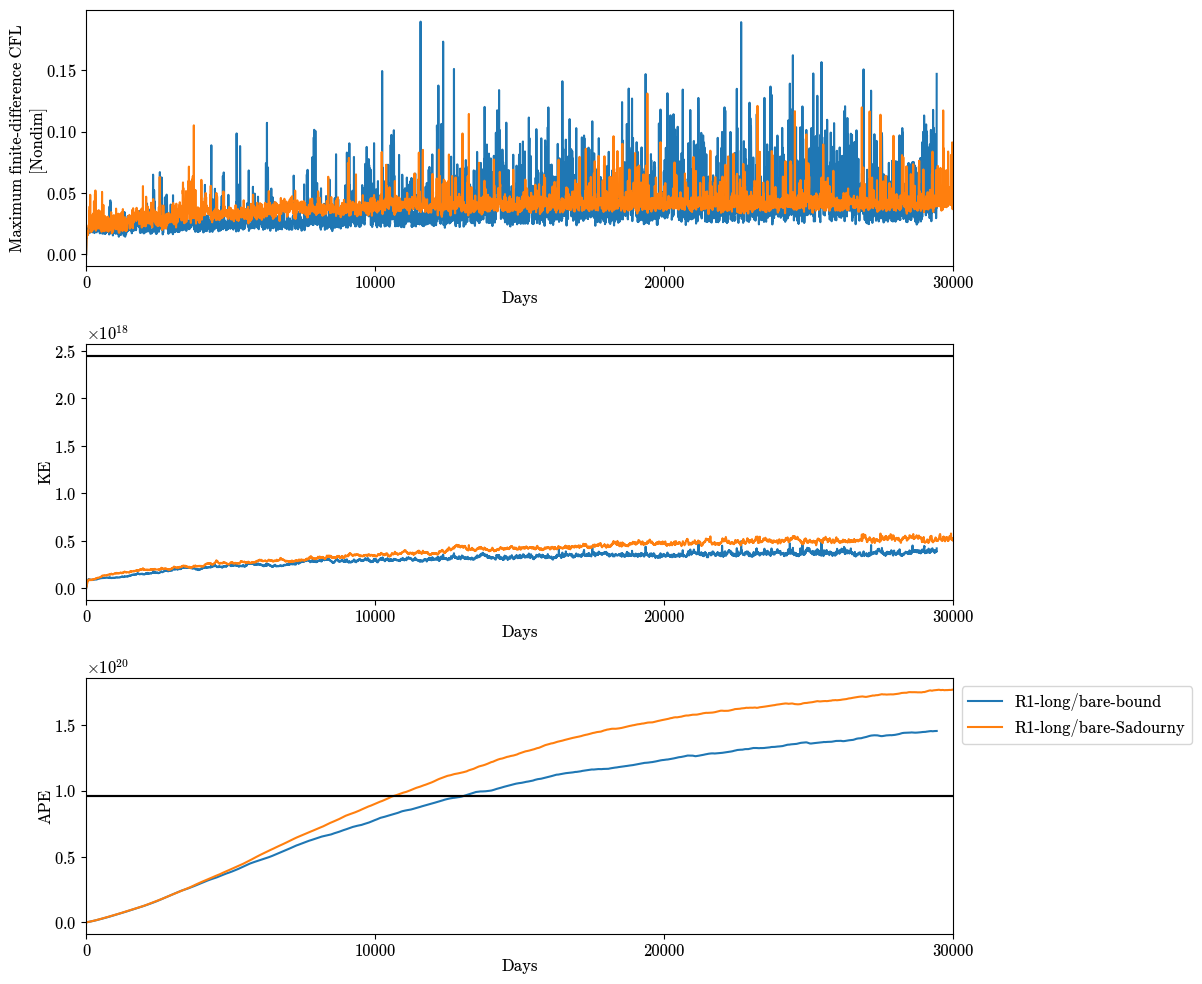

In [23]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-bound', 'R1-long/bare-Sadourny'])

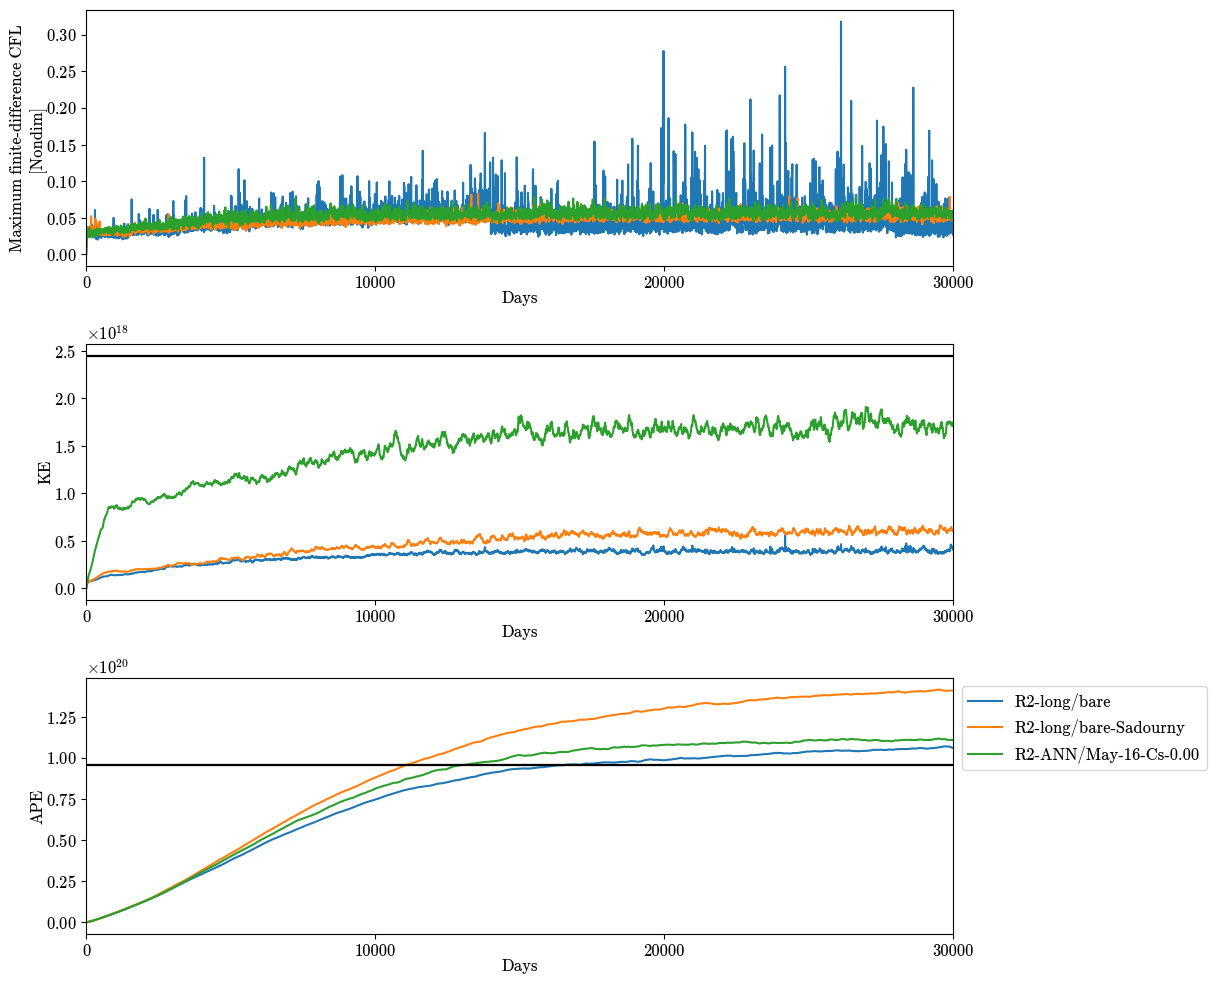

In [27]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R2-long/bare', 'R2-long/bare-Sadourny', 'R2-ANN/May-16-Cs-0.00'])

# Increasing eddy viscosity helps a bit to bound CFL but not much and deterioration in APE is observed

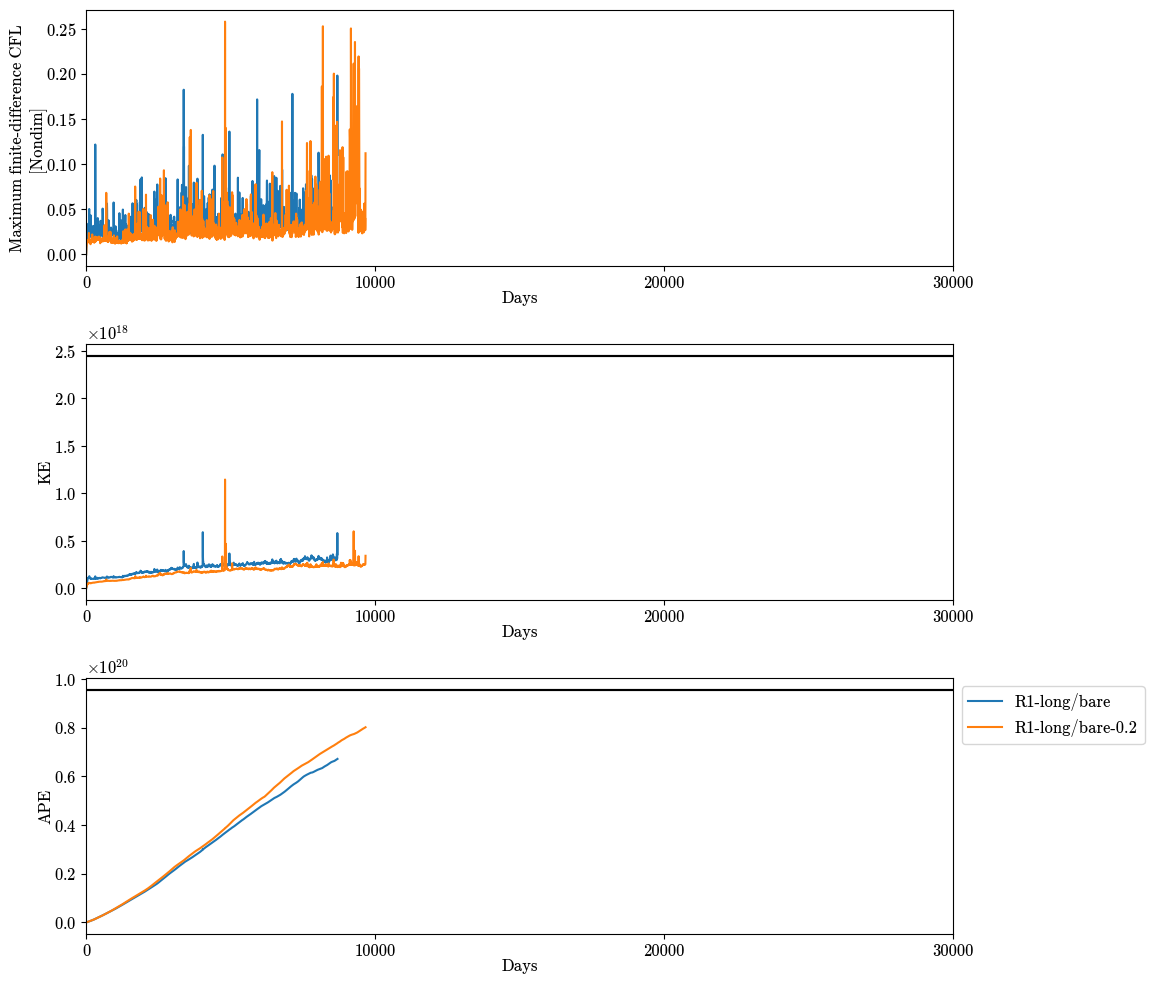

In [9]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare', 'R1-long/bare-0.2'])

# Coriolis bound helps with stability of the default NW2 numerical scheme but overshoots are still present. Effect on KE and APE is almost negligable.
Note: There is no effect of CORIOLIS_EN_DIS

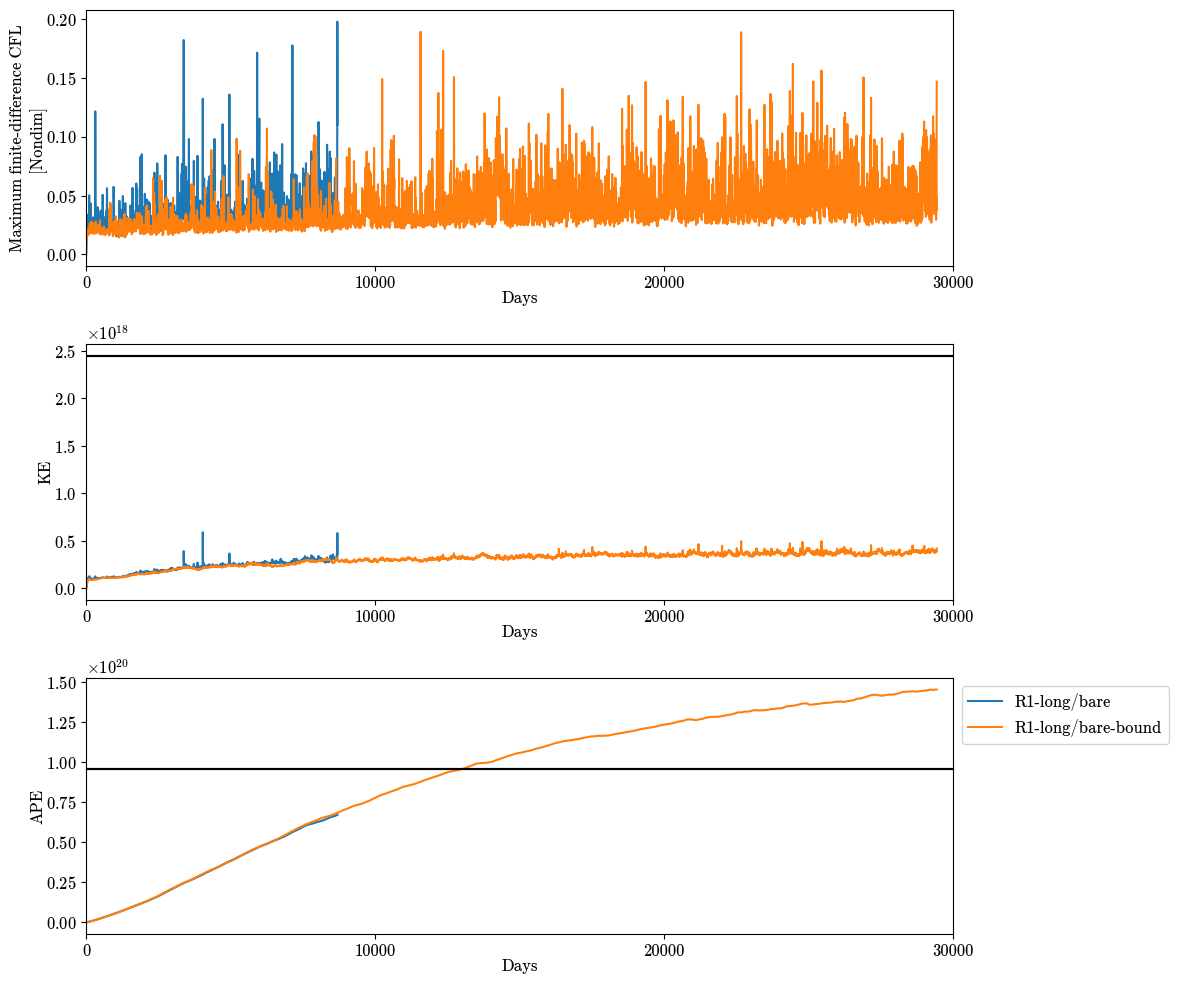

In [11]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare', 'R1-long/bare-bound'])

# Increaseing viscosity helps to reduce overshoots in CFL

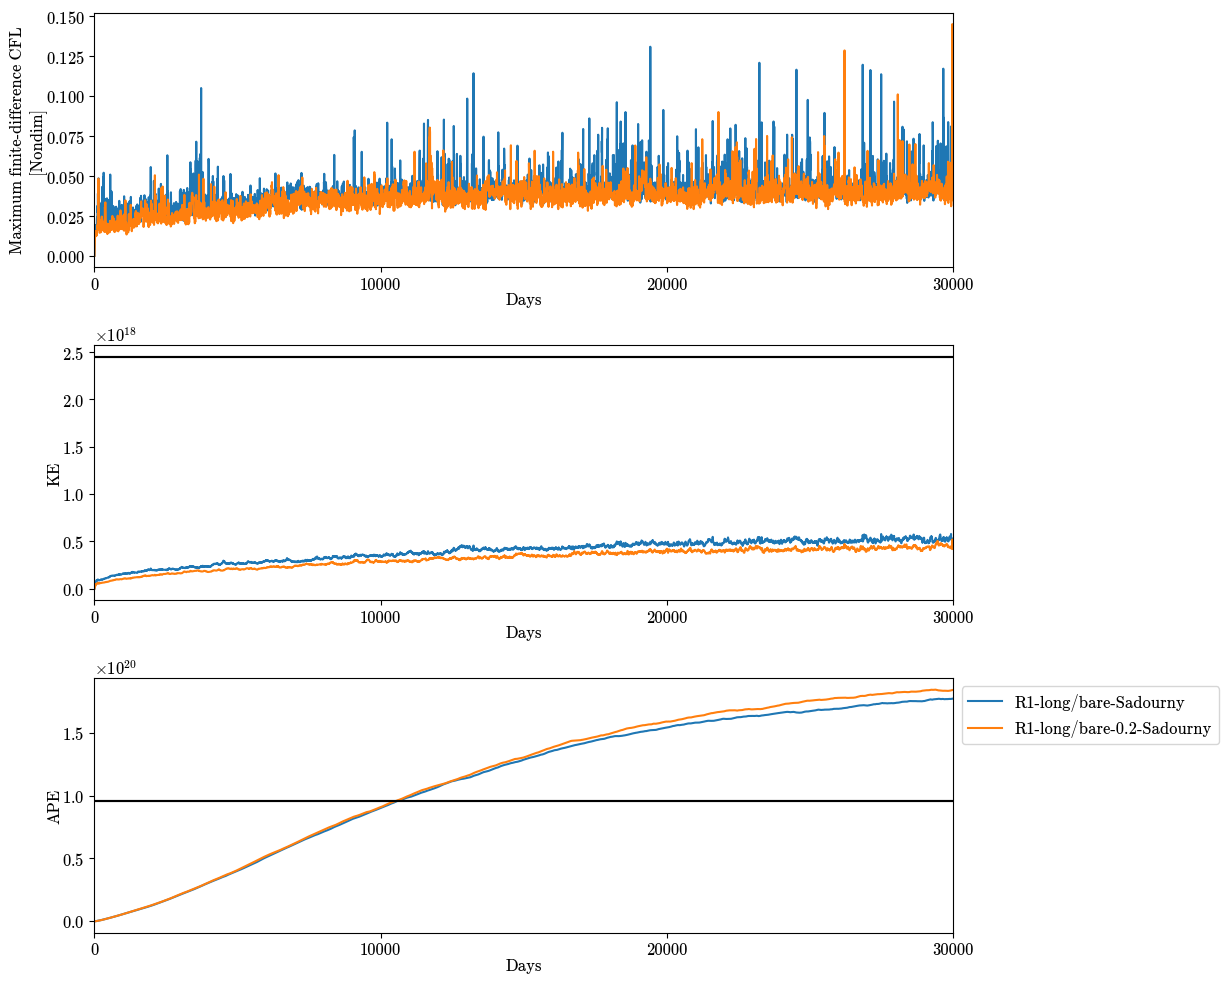

In [16]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-Sadourny', 'R1-long/bare-0.2-Sadourny'])

# Both bounding options considerably reduce overshoots in CFL, but diffusion is more important. Effect on KE/APE is present but not that large

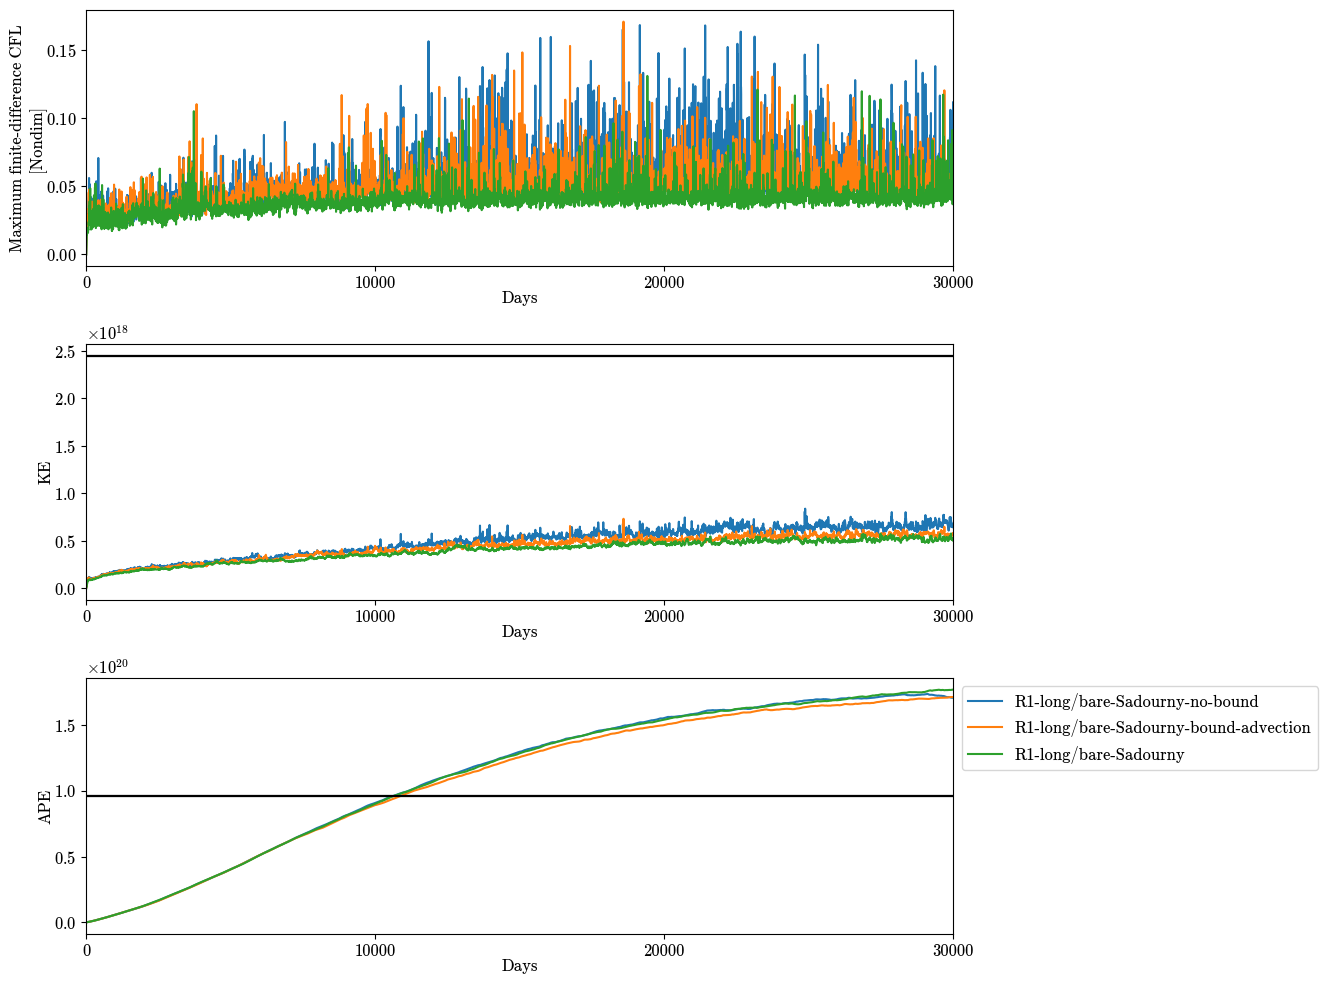

In [19]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-Sadourny-no-bound', 'R1-long/bare-Sadourny-bound-advection', 'R1-long/bare-Sadourny'])

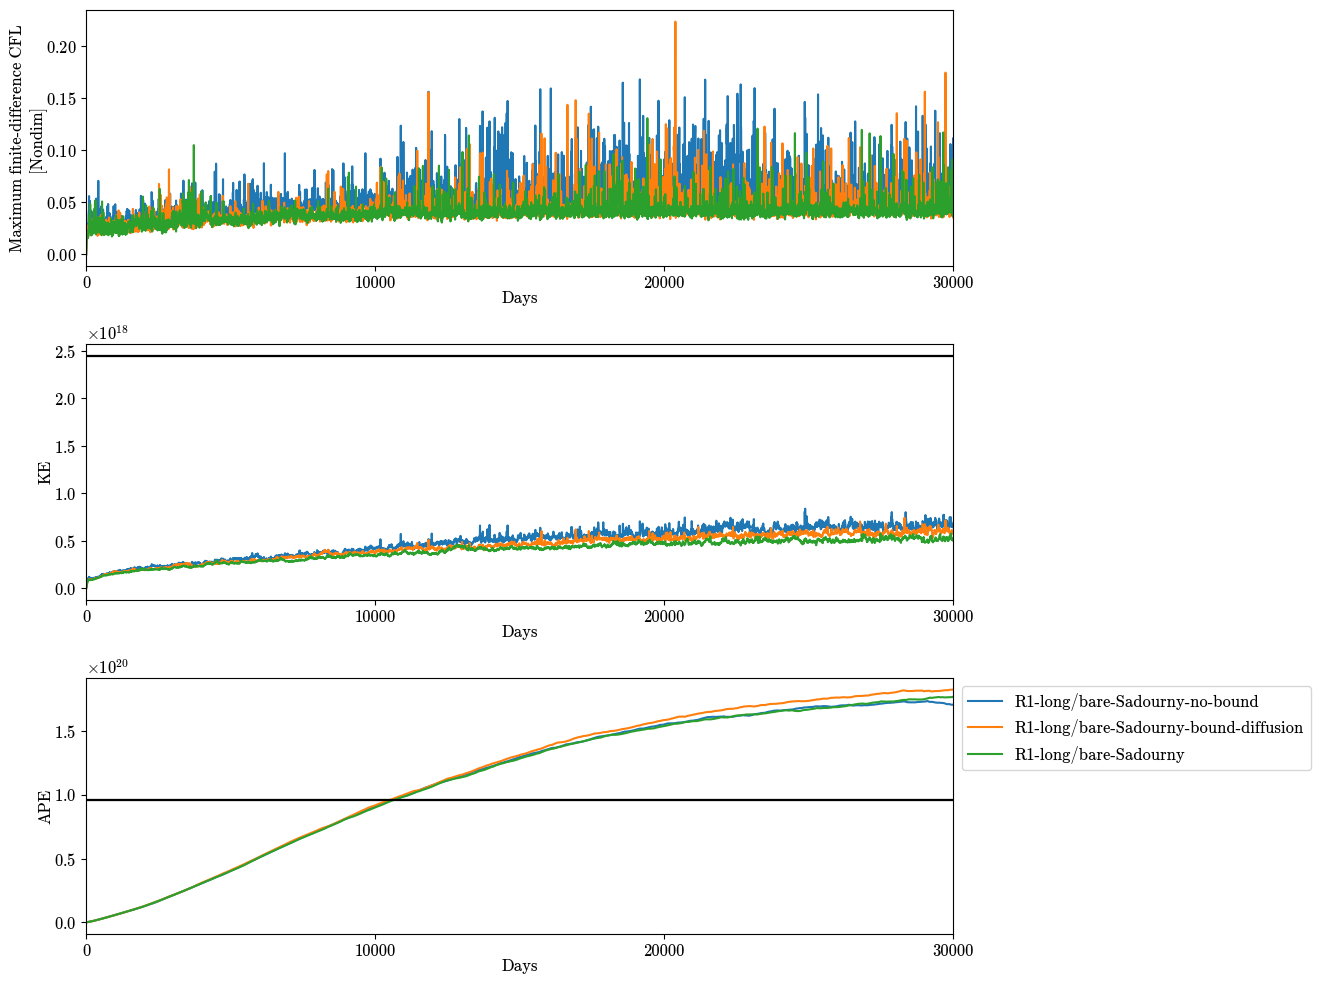

In [22]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-Sadourny-no-bound', 'R1-long/bare-Sadourny-bound-diffusion', 'R1-long/bare-Sadourny'])

# Coriolis dissipation option

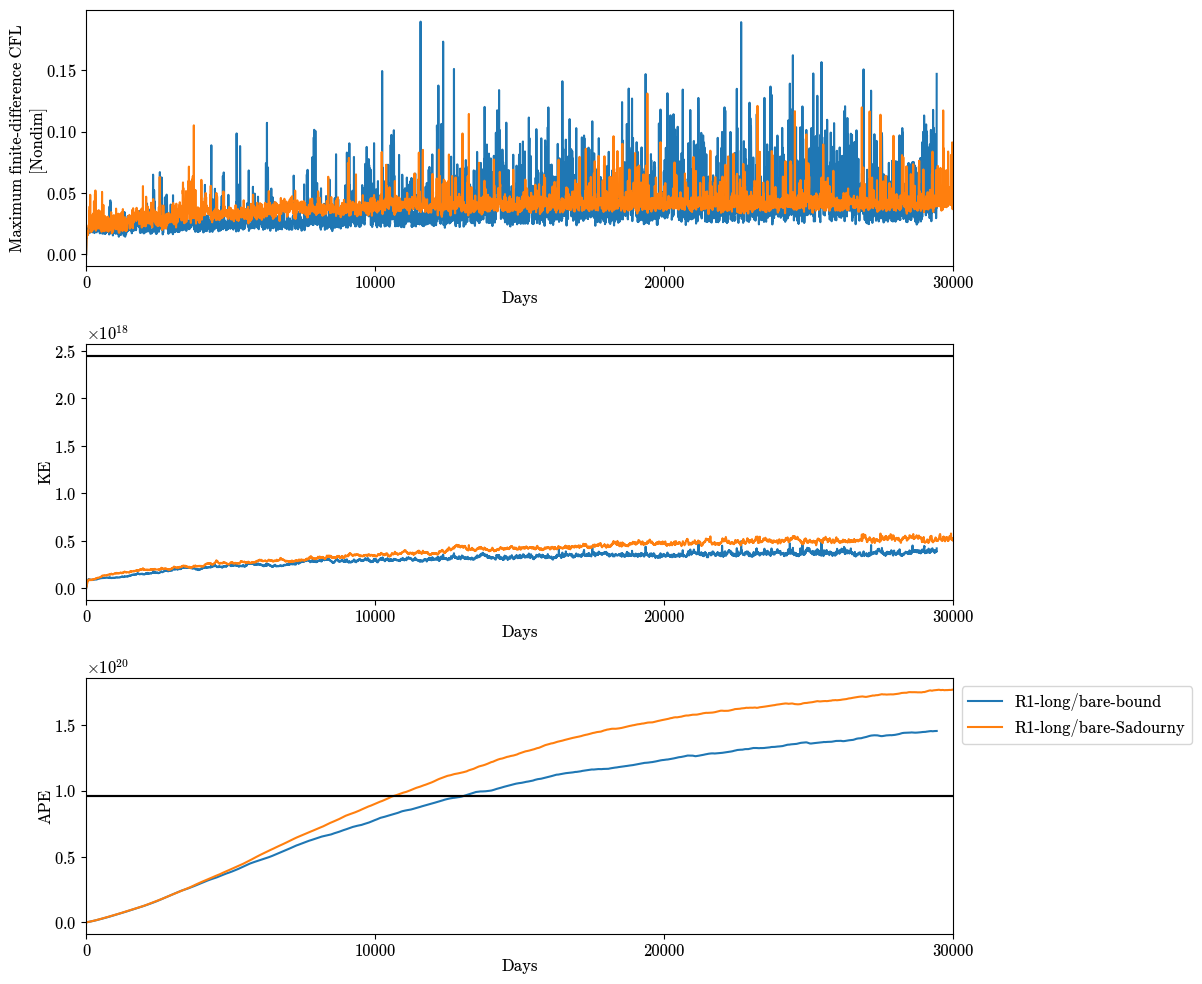

In [12]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-bound','R1-long/bare-Sadourny'])

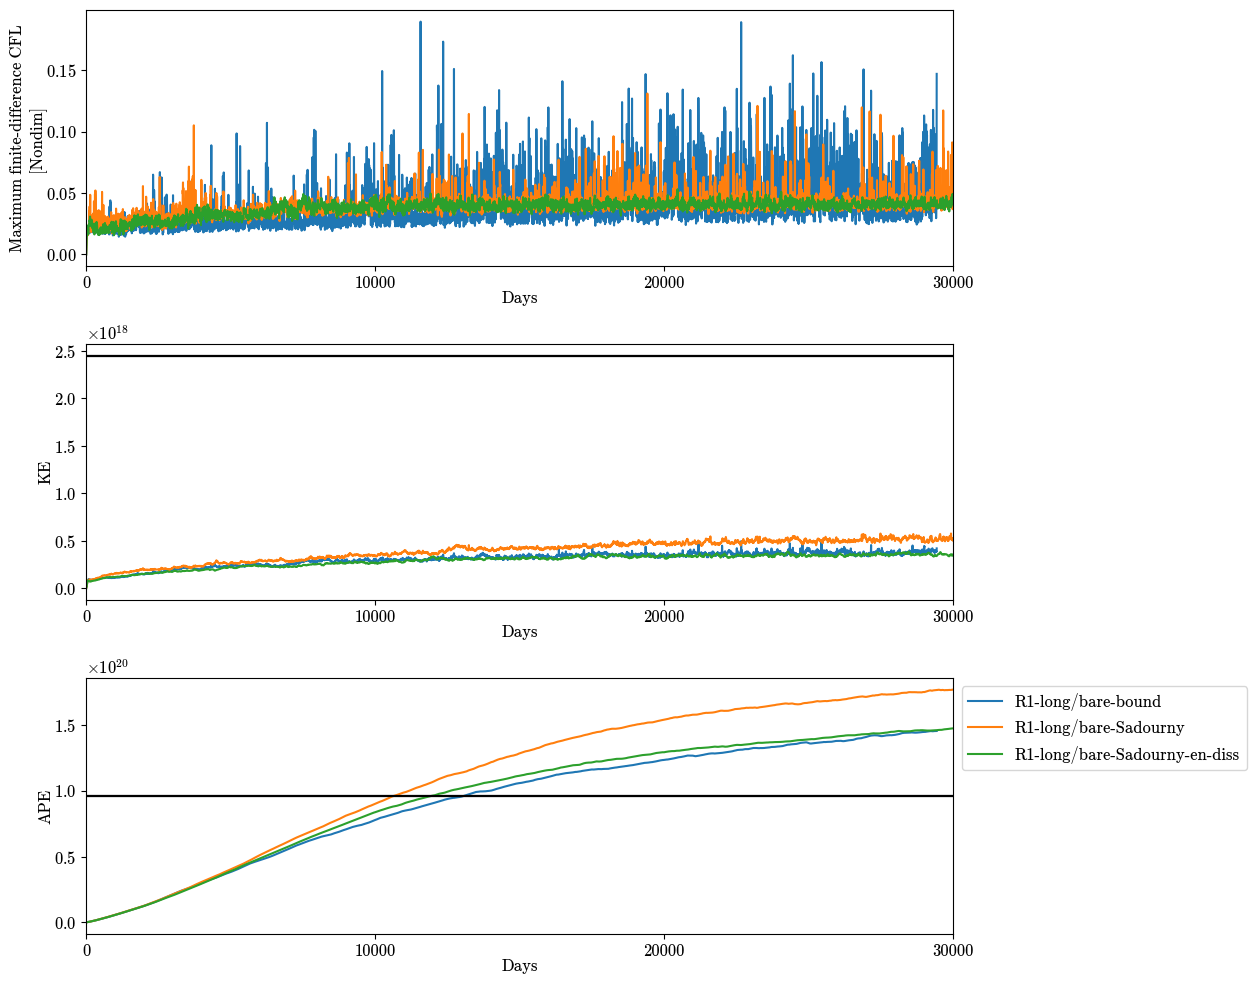

In [30]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-bound','R1-long/bare-Sadourny', 'R1-long/bare-Sadourny-en-diss'])

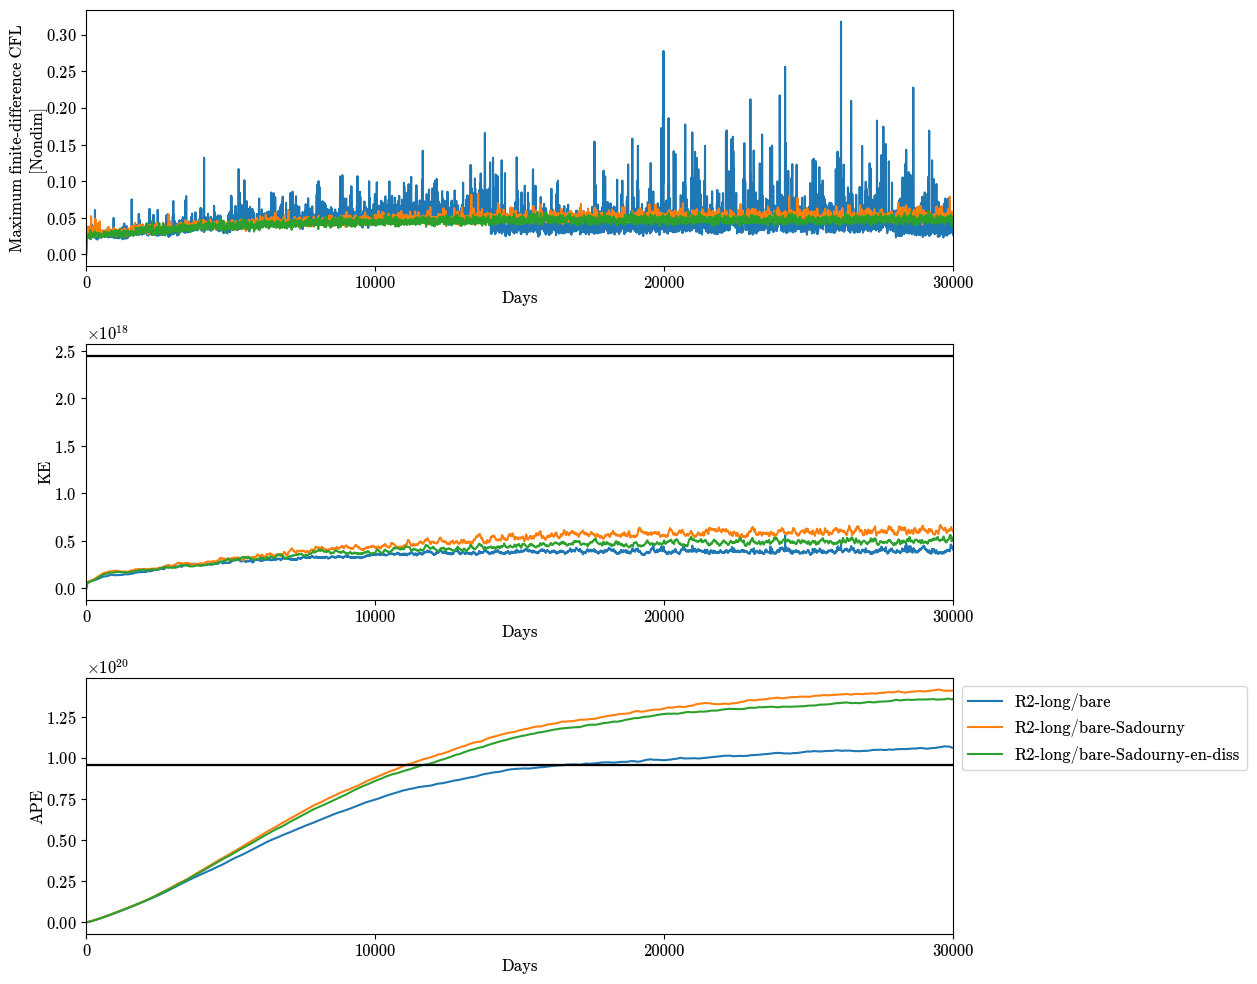

In [32]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R2-long/bare','R2-long/bare-Sadourny', 'R2-long/bare-Sadourny-en-diss'])

# Sadourny scheme at different resolutions

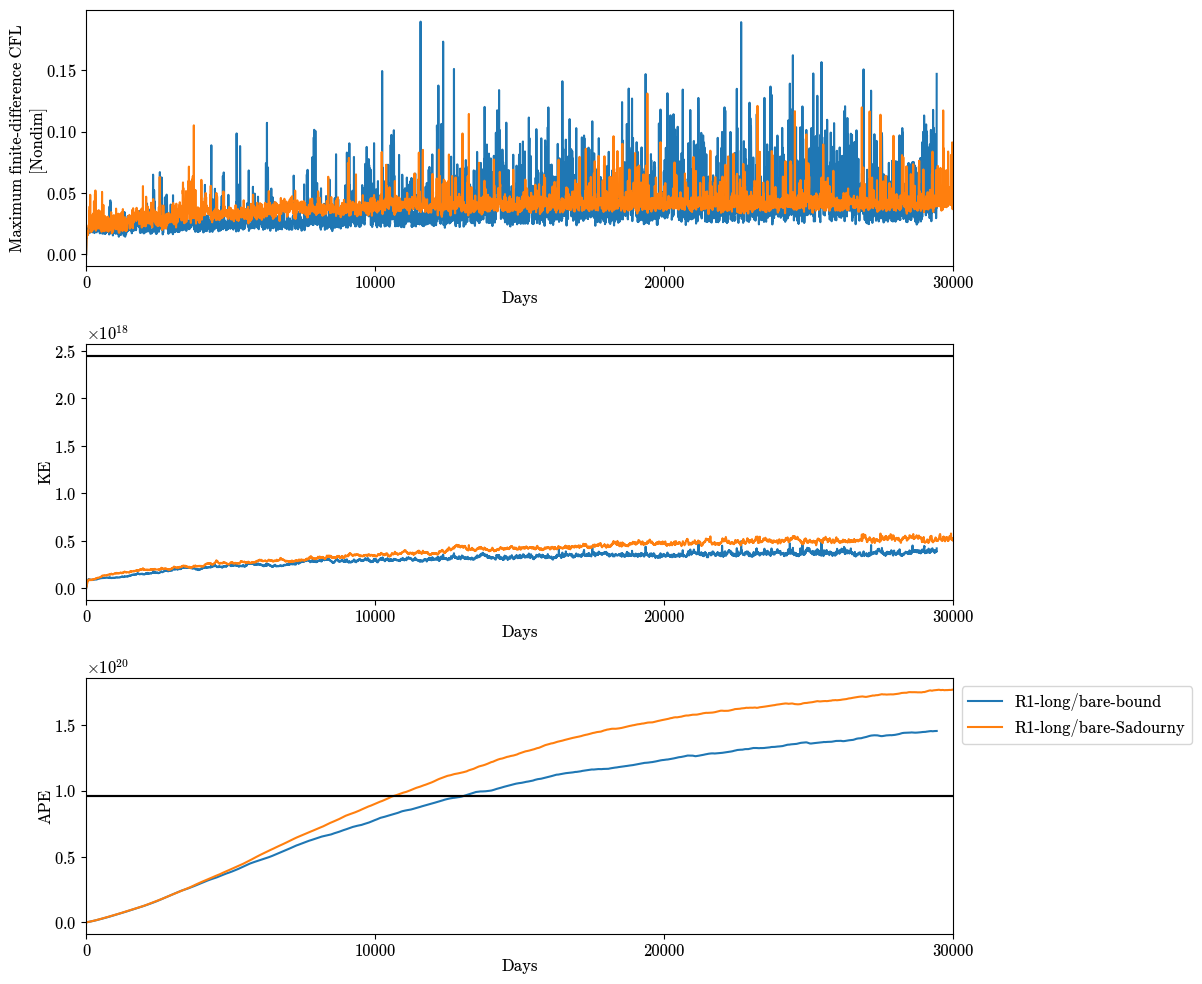

In [50]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R1-long/bare-bound','R1-long/bare-Sadourny'])

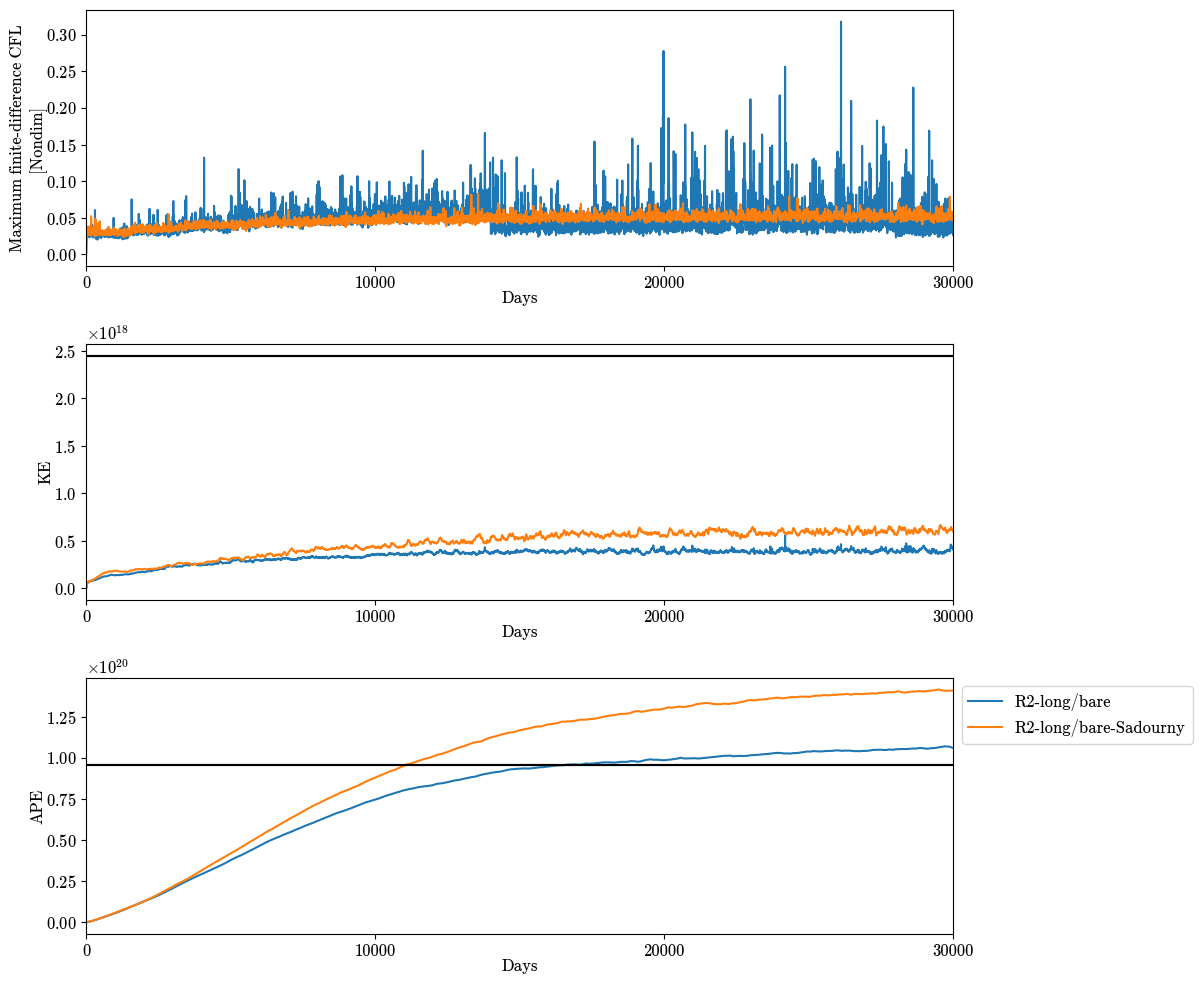

In [51]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R2-long/bare','R2-long/bare-Sadourny'])

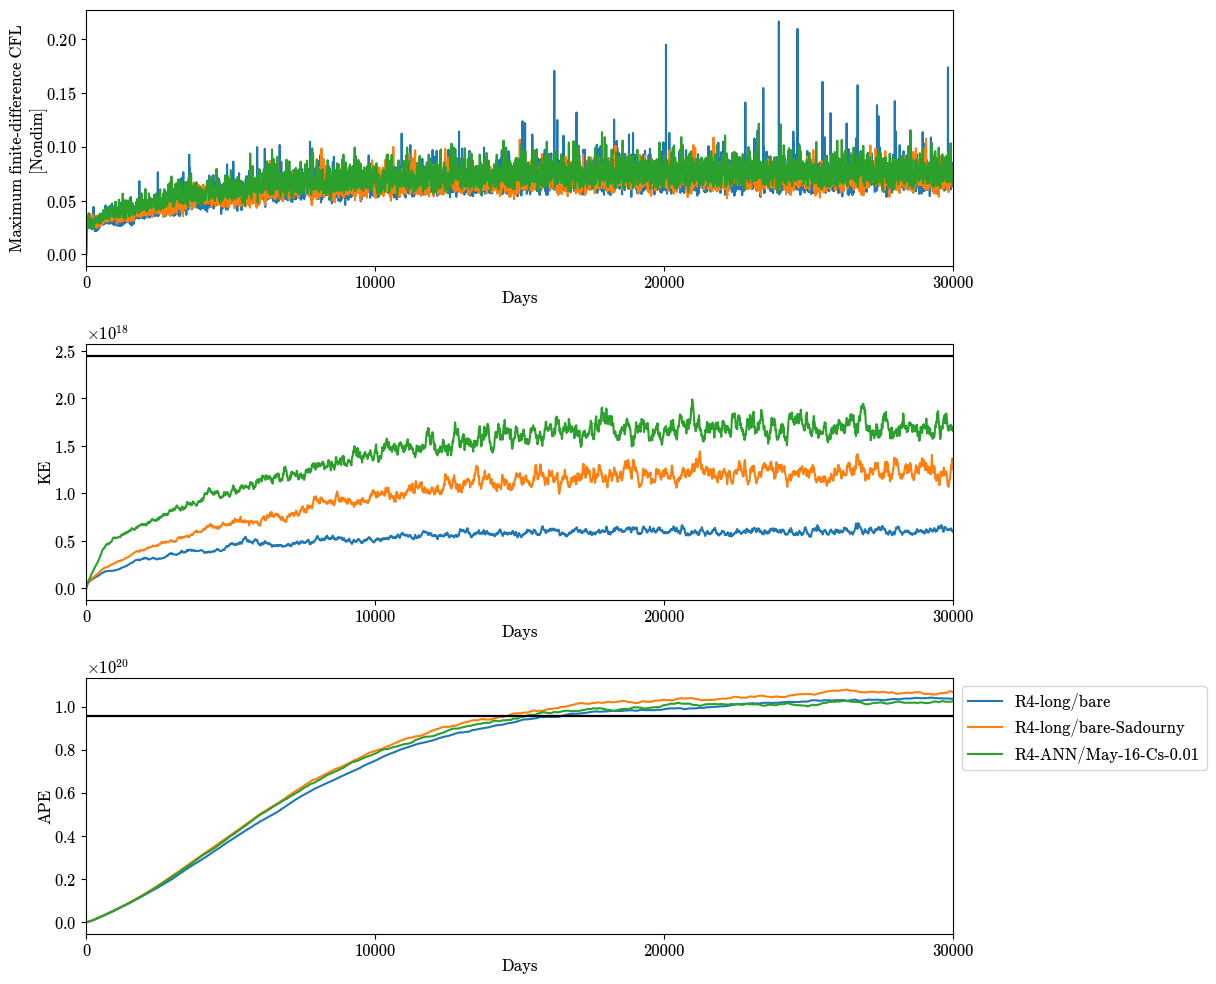

In [56]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R4-long/bare','R4-long/bare-Sadourny', 'R4-ANN/May-16-Cs-0.01'])

Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-long/bare exploded


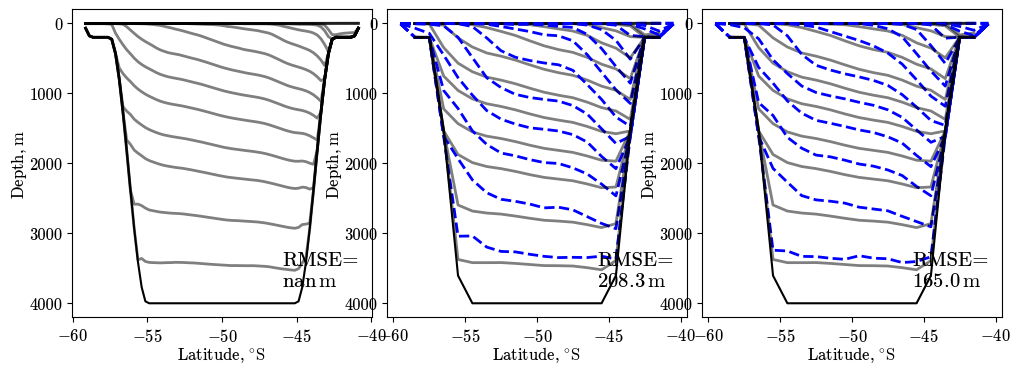

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R1-long/bare',lon=0))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R1-long/bare-Sadourny',lon=0))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R1-long/bare-Sadourny-en-diss',lon=0))

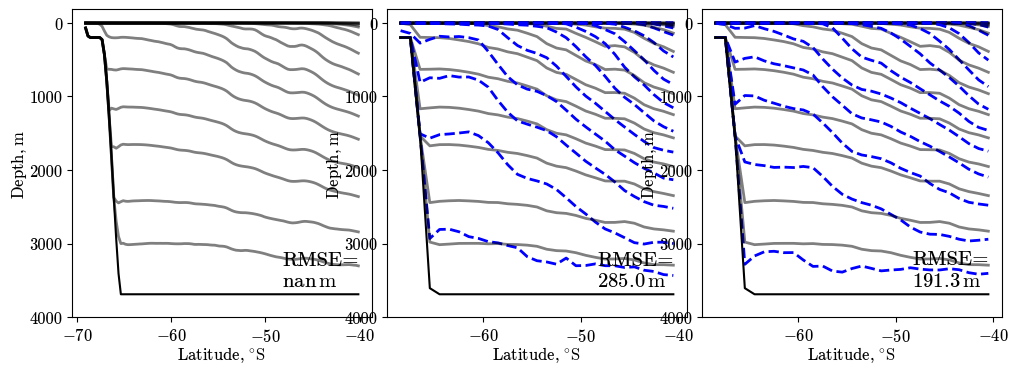

In [64]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R1-long/bare',lon=15, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R1-long/bare-Sadourny',lon=15, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R1-long/bare-Sadourny-en-diss',lon=15, lat_max=-40))

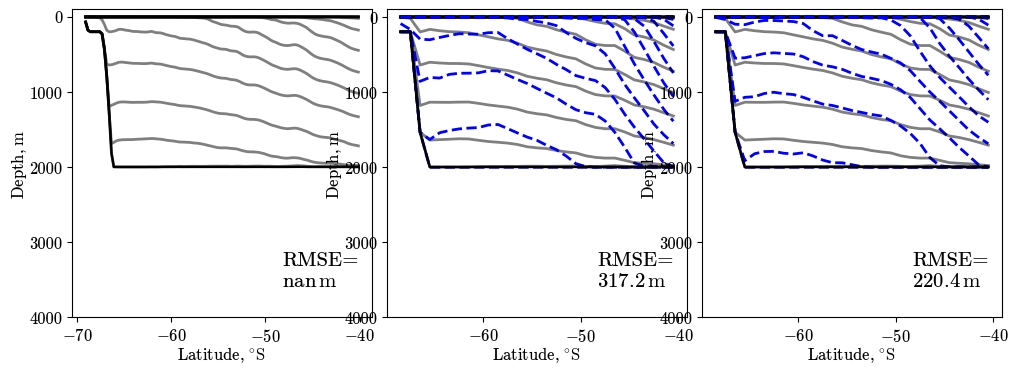

In [70]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R1-long/bare',lon=30, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R1-long/bare-Sadourny',lon=30, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R1-long/bare-Sadourny-en-diss',lon=30, lat_max=-40))

Experiment /scratch/pp2681/mom6/Neverworld2/simulations/R1-long/bare exploded


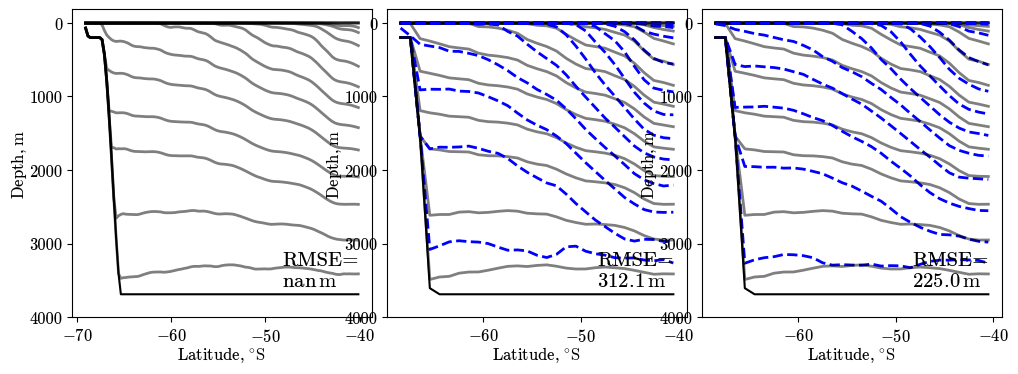

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R1-long/bare',lon=45, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R1-long/bare-Sadourny',lon=45, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R1-long/bare-Sadourny-en-diss',lon=45, lat_max=-40))

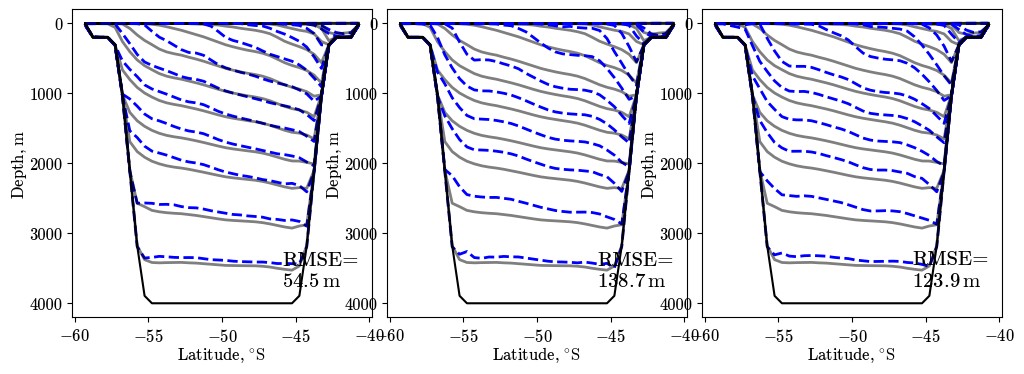

In [65]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=0))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-long/bare-Sadourny',lon=0))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-long/bare-Sadourny-en-diss',lon=0))

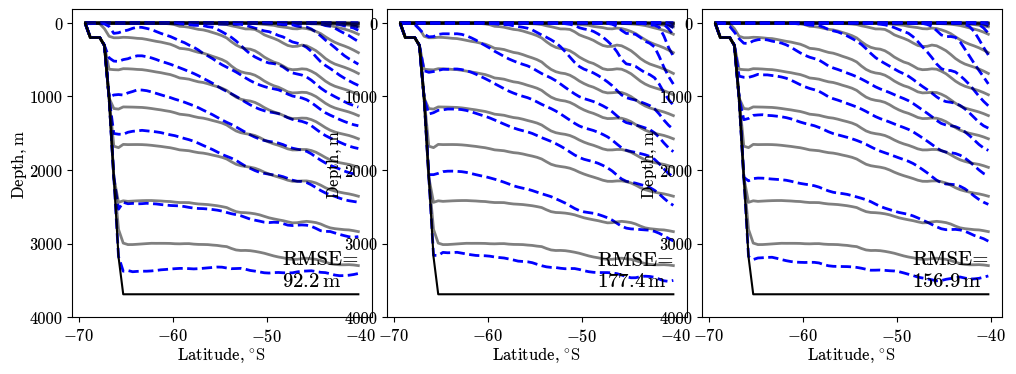

In [67]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=15, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-long/bare-Sadourny',lon=15, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-long/bare-Sadourny-en-diss',lon=15, lat_max=-40))

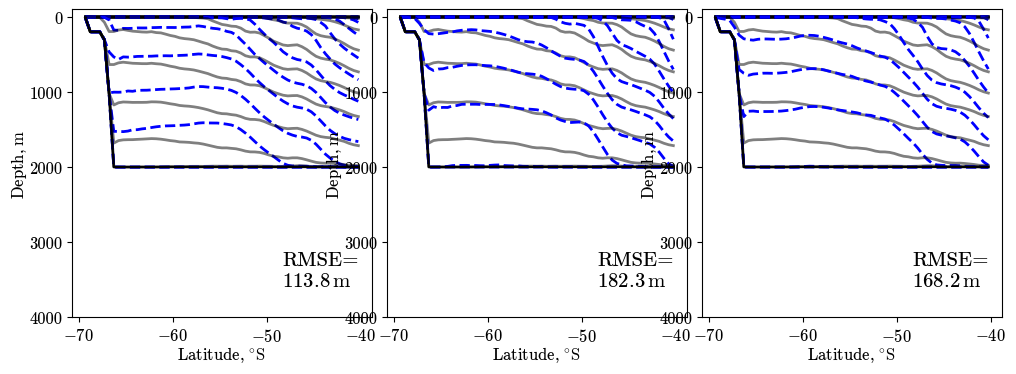

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=30, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-long/bare-Sadourny',lon=30, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-long/bare-Sadourny-en-diss',lon=30, lat_max=-40))

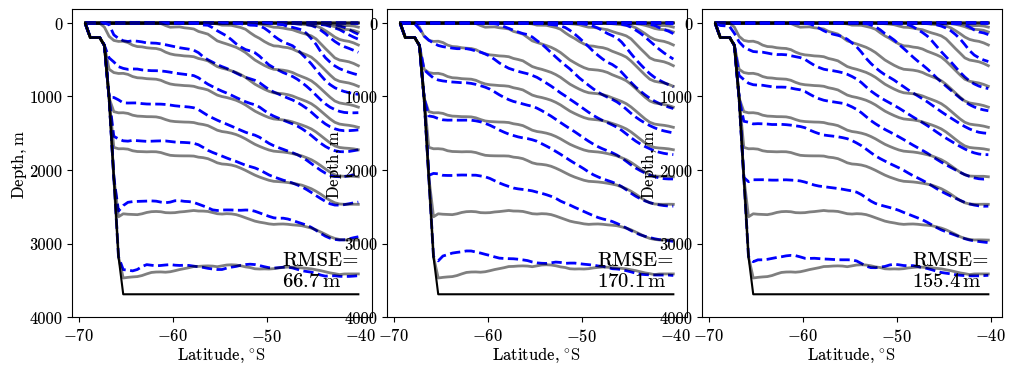

In [71]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=45, lat_max=-40))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-long/bare-Sadourny',lon=45, lat_max=-40))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-long/bare-Sadourny-en-diss',lon=45, lat_max=-40))

# Conclusion on CORIOLIS_EN_DISS option
While It seemsed to help with making Sadoruny scheme OK at 1-degree resolution, it does not help that much at half resolution (and probably quater, too).

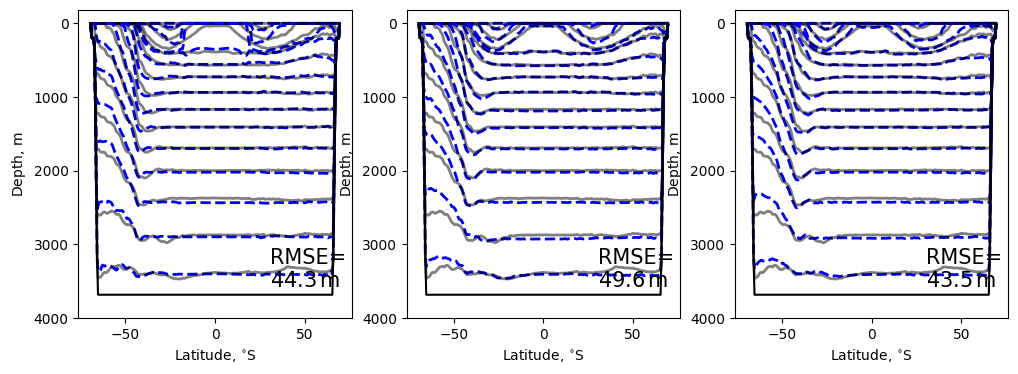

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=45))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01',lon=45))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01-en-diss',lon=45))

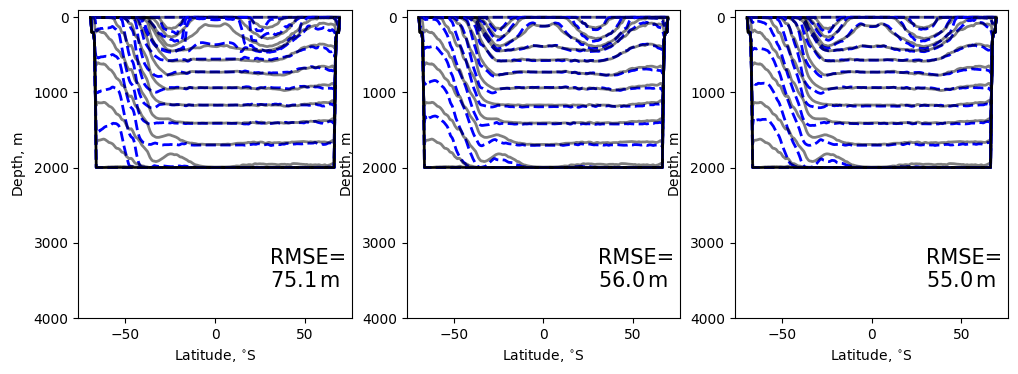

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=30, lat_max=None))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01',lon=30, lat_max=None))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01-en-diss',lon=30, lat_max=None))

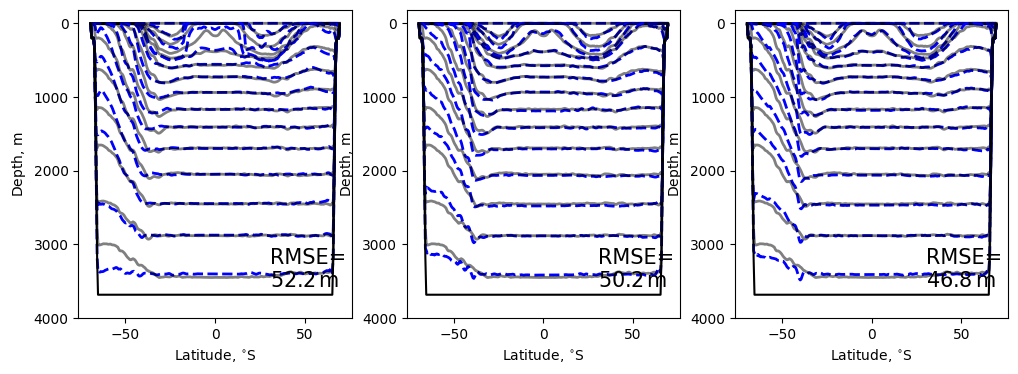

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=15, lat_max=None))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01',lon=15, lat_max=None))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01-en-diss',lon=15, lat_max=None))

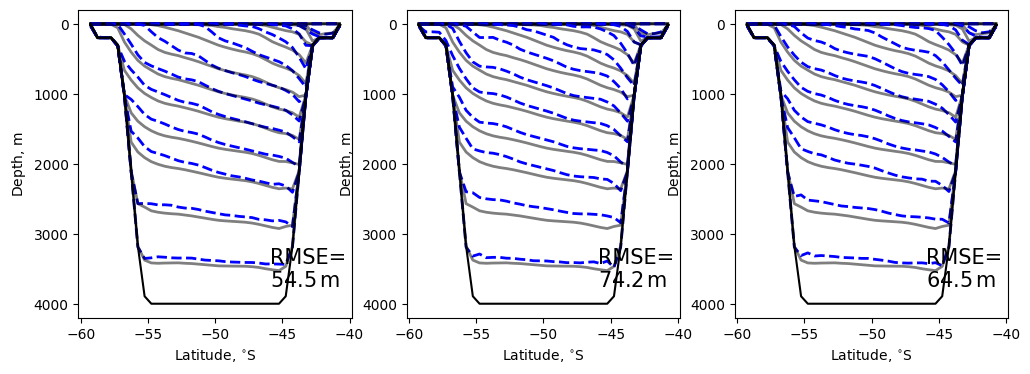

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_interfaces(*interfaces('R2-long/bare',lon=0, lat_max=None))
plt.subplot(1,3,2)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01',lon=0, lat_max=None))
plt.subplot(1,3,3)
plot_interfaces(*interfaces('R2-ANN/May-16-Cs-0.01-en-diss',lon=0, lat_max=None))